In [68]:
import os
import requests 
import time
import string
import networkx as nx
import itertools
import networkx as nx
import pandas as pd
import json
import re
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords

from nltk.corpus import wordnet as wn #importing it
from nltk.stem.wordnet import WordNetLemmatizer #importing wordnet lemmatizer
from nltk import pos_tag #part-of-speech-tagger
from collections import defaultdict #defaultdict returns default value for non-existant keys you try to  access based on the function you passed in the constructor
#from google.colab import files

import heapq
import json
import re
import csv
from wordcloud import WordCloud
nltk.download('stopwords')

from operator import itemgetter
import  collections
from operator import itemgetter

import random

[nltk_data] Error loading stopwords: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>


In [69]:
path="../LIWK_files/covid_coronavirus_vaccine_aggregration/"

america1L= pd.read_csv(path+'USA_JanFeb2020L.csv',dtype ={"Source (A)": str})
america2L= pd.read_csv(path+'USA_SeptOct2020L.csv',dtype ={"Source (A)": str})
america3L= pd.read_csv(path+'USA_MarchApril2021L.csv',dtype ={"Source (A)": str})

americaTL= pd.read_csv(path+'USAL.csv',dtype ={"Source (A)": str})


china1L= pd.read_csv(path+'China_JanFeb2020L.csv',dtype ={"Source (A)": str})
china2L= pd.read_csv(path+'China_SeptOct2020L.csv',dtype ={"Source (A)": str})
china3L= pd.read_csv(path+'China_MarchApril2021L.csv',dtype ={"Source (A)": str})

chinaTL= pd.read_csv(path+'ChinaL.csv',dtype ={"Source (A)": str})

In [70]:
def plot_wordcloud(dictionary):
    wordcloud = WordCloud(background_color='white',
                          width=1500,
                          height=1000
                          ).generate_from_frequencies(dictionary)
    # use .generate(space_separated_string) - to generate cloud from text

    plt.figure(figsize=(9,6))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

# functions from NS_word_meas
def cleaner(tweet,word_list = stopwords.words('english')):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) # remove mentions
    tweet = re.sub("#[A-Za-z0-9]+", "",tweet) # remove hashtags
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) # remove http links
    tweet = " ".join(tweet.split())
    tweet = str.lower(tweet) #to lowercase
    table = str.maketrans(dict.fromkeys(string.punctuation)) 
    tweet = tweet.translate(table)# remove punctuation

    special_characters = ['rt','dr','“','rt','the','to','of','a','an','on','has','have','had','is','was','did','n','et','ha','lt','1','2','5']

    tweet = tweet.split()      
    tweet = ' '.join([ word for word in tweet if word not in word_list and word not in special_characters  ])   #remove useless words
    return tweet



#initialize an empty dict

def frequency_dictionary(df):
    unique_words = {}

    for row in df:
        for word in row.split():
            #if the word is encountered for the first time add to dict as key and set its value to 0
            unique_words.setdefault(word,0)
            #increase the value (i.e the count) of the word by 1 every time it is encountered
            unique_words[word] += 1

    return unique_words

def frequency_marker_dictionary(df,df2,markstring):   ##dummy marker assignment
    mark_words = {}
    count_words = {}
    i=0
    for row in df:
        for word in row.split():
            #if the word is encountered for the first time add to dict as key and set its value to 0
            mark_words.setdefault(word, 0)
            count_words.setdefault(word, 0)
            #increase the value of a word by the average of the previous values and the new one tweet value
            mark_words[word] = mark_words[word] + df2.iloc[i][markstring]  
            count_words[word] += 1
        i+=1
    return mark_words, count_words

# this is the code provided by Lejla for cleaning, lemmatising and pos tagging tweets

nltk.download('words')
words = set(nltk.corpus.words.words()) #the last two lines serve to download the corpus of standard English language words
nltk.download('stopwords') #downloading stopwords
stop_words = set(nltk.corpus.stopwords.words("english")) #taking the stop words from English language
nltk.download('wordnet') #downloading wordnet
from nltk.corpus import wordnet as wn #importing it
from nltk.stem.wordnet import WordNetLemmatizer #importing wordnet lemmatizer
from nltk import pos_tag #part-of-speech-tagger
nltk.download('averaged_perceptron_tagger') #downloading tagger
from collections import defaultdict #defaultdict returns default value for non-existant keys you try to  access based on the function you passed in the constructor
tag_map = defaultdict(lambda : wn.NOUN) #here we define that wn.NOUN is the default value for the dict
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

def lemma_pos_cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) # remove mentions
    tweet = re.sub("#[A-Za-z0-9]+", "",tweet) # remove hashtags
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) # remove http links
    tweet = " ".join(tweet.split())
    tweet = str.lower(tweet) #to lowercase
    tweet = re.sub("'", " ", tweet)  # remove aphostrophe

    #basically we use pos_tag function on tokens that we get by applying wordpunct tokenization
    #to tweet (it separates all the words and symbols)
    #then we pass the token along with it's wordnet pos value that we get from the tag_map dictionary (noun, adjective, verb or adverb) to the lemma function (the WordNetLemmatizer())
    lemma_function = WordNetLemmatizer()
    tweet = " ".join(lemma_function.lemmatize(token, tag_map[tag[0]]) for token, tag in nltk.pos_tag(nltk.wordpunct_tokenize(tweet))) #lemmatize

    # francesco: I removed also all 2 letters words and added specific words, words that appears frequently but are discarded because they are not in the english language and len(w)>2
    specific_words=['virus', 'coronavirus', 'covid19', 'covid', 'trump', 'hubei', 'beijing', 'xinjiang', 'jinping', 'korea', 'xinhua', 'india', 'taiwan','johnson','singapore', 'africa', 'japanese', 'france', 'asian', 'australia', 'french', 'asia', 'leishenshan', 'british', 'qingdao', 'fauci', 'america',  'california', 'sichuan', 'malaysia', 'huawei','thailand', 'shandong', 'italy', 'philippines', 'germany', 'facebook', 'african', 'shenzhen', 'tokyo', 'russian','uygur', '5g', 'pompeo', 'vietnam', 'australian', 'cambodia', 'zhejiang', 'yunnan', 'guangdong', 'korean', 'iran', 'washington']
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) if (w in words or w in specific_words) and w not in stop_words ) #remove stop words
   
    return tweet

## Adjacency matrix building
def adj_matrix(freq_dict,cleaned_df_text):   

    words = sorted(list(freq_dict.keys()))

    A = pd.DataFrame(np.zeros((len(words),len(words))), columns = words, index = words )

    for phrase in cleaned_df_text:

        words_list = phrase.split()

        couples = [(words_list[i],words_list[j]) for i in range(len(words_list)) for j in range(i+1,len(words_list))]

        for w1,w2 in couples:

              A.loc[w1,w2] += 1

    return np.maximum( A, A.transpose() )

def threshold(vector,threshold):

    l = [(el,vector[el]) for el in vector if vector[el] >= threshold ]

    print(pd.DataFrame(l))

    return 

[nltk_data] Error loading words: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>
[nltk_data] Error loading stopwords: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>
[nltk_data] Error loading wordnet: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno -2] Name or service not known>


In [71]:
china1L["Source (B)"]

0        'CGTN talked to W. Ian Lipkin of Columbia Uni...
1        'China and the world has made great strides i...
2       RT @CGTNEurope: A fake news story about cases ...
3       RT @CGTNEurope: #COVID19: Transmission outside...
4       RT @cgtnafrica: The World Health Organization ...
                              ...                        
2393     'The 14-month-old boy who was the first confi...
2394    New #COVID-19 cases outside Hubei drop for 10t...
2395     'The first batch of 28 patients who had recov...
2396    Hubei's virus-hit county will rebuild a hospit...
2397     "Chinese researchers develop a portable detec...
Name: Source (B), Length: 2398, dtype: object

In [72]:
def get_adj_matrix(df):
    text = [lemma_pos_cleaner(txt) for txt in df["Source (B)"]]
    freq_dict = frequency_dictionary(text)
    freq_dict = dict(sorted(freq_dict.items(), key=lambda item: item[1], reverse = True))   #order from more frequent to less frequent word

    A = adj_matrix(freq_dict, text)
    return freq_dict, A

# create the unnormalized adjency matrix B of the bipartite graph!!!

def unm_adj_matrix(freq_dict,cleaned_df_text,id_tweet):   

    words = sorted(list(freq_dict.keys()))

    B = pd.DataFrame(np.zeros((len(cleaned_df_text),len(words))), columns = words, index = id_tweet )
    
    for i , phrase in enumerate(cleaned_df_text) :
        words_list = phrase.split()
        for w in words_list :
            
            B.loc[id_tweet.loc[i],w] = 1
    
    #B_tw_tw = pd.DataFrame(np.zeros((len(cleaned_df_text),len(cleaned_df_text))), columns = id_tweet, index = id_tweet )
    #B_w_w  =  pd.DataFrame(np.zeros((len(words),len(words))), columns = words, index = words )    
    return B

def power_iteration(A, m_t0 ,num_simulations: int,alpha=0.85):
    '''
    A   : is the matrix of which you want the eigenvalue
    m_t0: is the starter value
    
    '''
    m_t=m_t0
    for _ in range(num_simulations):
        # calculate the matrix-by-vector product Ab
        m_t1 = alpha * np.dot(A, m_t) + (1.-alpha)*m_t0
        
        # calculate the norm   (here I sum the whole vector and then I divide it)
        m_t1_norm = np.linalg.norm(m_t1,ord=1) 

        # re normalize the vector
        m_t = m_t1 / m_t1_norm #m_t1.sum()
        #print(m_t)

    return m_t



def pgrank_projection(df, emo = "negemo", n_iteration = 10, plotWC= True ):
    
    #check that the dataframe have no 0-words tweet
    check_df = len(df[df["WC"] == 0])
    if check_df != 0:
        print("dumping",check_df , "rows")
        df.drop(df[df["WC"] == 0].index, inplace=True, axis=0)  #notice it should affect the original df
        
    df_text = df["Source (B)"]
    id_tweet = df["Source (A)"].reset_index(drop=True)
    
    
    
    cleaned_df_text = [lemma_pos_cleaner(el) for el in df_text]
    marker_dict, freq_dict = frequency_marker_dictionary(cleaned_df_text, df, emo )

    B=unm_adj_matrix(freq_dict,cleaned_df_text,id_tweet )
    
    #spot difficulties in the dataframe : 
    #assert len(B.loc[B.sum(axis=1) == 0])== 0 , "Check the data !! Possible 0-word tweet!"
    check = B.loc[B.sum(axis=1) == 0]
    if len(check)!= 0  :  
        print(check.index)
        assert True, "Check the data !! Possible 0-word tweet!"
    
    
    B1 = B / np.linalg.norm(B,ord=1,axis=1, keepdims=True)
    
    B2_tmp = B / np.linalg.norm(B,ord=1,axis=0, keepdims=True)
    B2=B2_tmp.transpose()
    
    Mt = B1.dot(B2) #I started with the transposed B!!! 
    m_i = df[emo].reset_index(drop=True)
    
    m_t=power_iteration(Mt,m_i, n_iteration)
    m_w =B2.dot(np.array(m_t))
    if plotWC == True : plot_wordcloud(m_w.to_dict())
    
    return B, m_t , m_w 

In [73]:
#get adj matrixs
#take ages
fc1,Ac1 = get_adj_matrix(china1L)
fc2,Ac2 = get_adj_matrix(china2L)
fc3,Ac3 = get_adj_matrix(china3L)
fa1,Aa1 = get_adj_matrix(america1L)
fa2,Aa2 = get_adj_matrix(america2L)
fa3,Aa3 = get_adj_matrix(america3L)

C1 = nx.from_pandas_adjacency(Ac1)
C2 = nx.from_pandas_adjacency(Ac2)
C3 = nx.from_pandas_adjacency(Ac3)
A1 = nx.from_pandas_adjacency(Aa1)
A2 = nx.from_pandas_adjacency(Aa2)
A3 = nx.from_pandas_adjacency(Aa3)


In [75]:
america2L[america2L['Source (A)']== '1312041956084678656']["Source (B)"]
america2L.drop(america2L[america2L['Source (A)']== '1312041956084678656'].index, inplace=True, axis=0)

In [76]:
china2L[china2L['Source (A)']== '1316614782095482880']["Source (B)"]
china2L.drop(china2L[china2L['Source (A)']== '1316614782095482880'].index, inplace=True, axis=0)

In [77]:
china3L[china3L['Source (A)']== '1372064322671669248']["Source (B)"]
china3L.drop(china3L[china3L['Source (A)']== '1372064322671669248'].index, inplace=True, axis=0)
china3L.drop(china3L[china3L['Source (A)']== '1378361852212641793'].index, inplace=True, axis=0)

In [78]:
china1L[china1L['Source (A)']== '1222512218052235264']["Source (B)"]
china1L.drop(china1L[china1L['Source (A)']== '1222512218052235264'].index, inplace=True, axis=0)

In [79]:
def get_B_mw(df,emo_str):
    B,m_t_,m_w_ = pgrank_projection(df, emo = emo_str, n_iteration = 20, plotWC= False )
    m_w_ord =dict(sorted(m_w_.to_dict().items(), key=lambda item: item[1],reverse  = True))
    return m_w_ord
#take edges
emo="negemo"
mw_c1 = get_B_mw(china1L,emo)
mw_c2 = get_B_mw(china2L,emo)
mw_c3 = get_B_mw(china3L,emo)
mw_a1 = get_B_mw(america1L,emo)
mw_a2 = get_B_mw(america2L,emo)
mw_a3 = get_B_mw(america3L,emo)

nx.set_node_attributes(C1, mw_c1,name = emo)
nx.set_node_attributes(C2, mw_c2,name = emo)
nx.set_node_attributes(C3, mw_c3,name = emo)
nx.set_node_attributes(A1, mw_a1,name = emo)
nx.set_node_attributes(A2, mw_a2,name = emo)
nx.set_node_attributes(A3, mw_a3,name = emo)

In [80]:
emo="posemo"
mw_c1p = get_B_mw(china1L,emo)
mw_c2p= get_B_mw(china2L,emo)
mw_c3p = get_B_mw(china3L,emo)
mw_a1p = get_B_mw(america1L,emo)
mw_a2p = get_B_mw(america2L,emo)
mw_a3p= get_B_mw(america3L,emo)

nx.set_node_attributes(C1, mw_c1p,name = emo)
nx.set_node_attributes(C2, mw_c2p,name = emo)
nx.set_node_attributes(C3, mw_c3p,name = emo)
nx.set_node_attributes(A1, mw_a1p,name = emo)
nx.set_node_attributes(A2, mw_a2p,name = emo)
nx.set_node_attributes(A3, mw_a3p,name = emo)

In [96]:
emo="death"
mw_c1p = get_B_mw(china1L,emo)
mw_c2p= get_B_mw(china2L,emo)
mw_c3p = get_B_mw(china3L,emo)
mw_a1p = get_B_mw(america1L,emo)
mw_a2p = get_B_mw(america2L,emo)
mw_a3p= get_B_mw(america3L,emo)

nx.set_node_attributes(C1, mw_c1p,name = emo)
nx.set_node_attributes(C2, mw_c2p,name = emo)
nx.set_node_attributes(C3, mw_c3p,name = emo)
nx.set_node_attributes(A1, mw_a1p,name = emo)
nx.set_node_attributes(A2, mw_a2p,name = emo)
nx.set_node_attributes(A3, mw_a3p,name = emo)

In [97]:
emo="they"
mw_c1p = get_B_mw(china1L,emo)
mw_c2p= get_B_mw(china2L,emo)
mw_c3p = get_B_mw(china3L,emo)
mw_a1p = get_B_mw(america1L,emo)
mw_a2p = get_B_mw(america2L,emo)
mw_a3p= get_B_mw(america3L,emo)

nx.set_node_attributes(C1, mw_c1p,name = emo)
nx.set_node_attributes(C2, mw_c2p,name = emo)
nx.set_node_attributes(C3, mw_c3p,name = emo)
nx.set_node_attributes(A1, mw_a1p,name = emo)
nx.set_node_attributes(A2, mw_a2p,name = emo)
nx.set_node_attributes(A3, mw_a3p,name = emo)

In [104]:
emo="we"
mw_c1p = get_B_mw(china1L,emo)
mw_c2p= get_B_mw(china2L,emo)
mw_c3p = get_B_mw(china3L,emo)
mw_a1p = get_B_mw(america1L,emo)
mw_a2p = get_B_mw(america2L,emo)
mw_a3p= get_B_mw(america3L,emo)

nx.set_node_attributes(C1, mw_c1p,name = emo)
nx.set_node_attributes(C2, mw_c2p,name = emo)
nx.set_node_attributes(C3, mw_c3p,name = emo)
nx.set_node_attributes(A1, mw_a1p,name = emo)
nx.set_node_attributes(A2, mw_a2p,name = emo)
nx.set_node_attributes(A3, mw_a3p,name = emo)

In [105]:
emo="focusfuture"
mw_c1p = get_B_mw(china1L,emo)
mw_c2p= get_B_mw(china2L,emo)
mw_c3p = get_B_mw(china3L,emo)
mw_a1p = get_B_mw(america1L,emo)
mw_a2p = get_B_mw(america2L,emo)
mw_a3p= get_B_mw(america3L,emo)

nx.set_node_attributes(C1, mw_c1p,name = emo)
nx.set_node_attributes(C2, mw_c2p,name = emo)
nx.set_node_attributes(C3, mw_c3p,name = emo)
nx.set_node_attributes(A1, mw_a1p,name = emo)
nx.set_node_attributes(A2, mw_a2p,name = emo)
nx.set_node_attributes(A3, mw_a3p,name = emo)

In [106]:
emo="focuspast"
mw_c1p = get_B_mw(china1L,emo)
mw_c2p= get_B_mw(china2L,emo)
mw_c3p = get_B_mw(china3L,emo)
mw_a1p = get_B_mw(america1L,emo)
mw_a2p = get_B_mw(america2L,emo)
mw_a3p= get_B_mw(america3L,emo)

nx.set_node_attributes(C1, mw_c1p,name = emo)
nx.set_node_attributes(C2, mw_c2p,name = emo)
nx.set_node_attributes(C3, mw_c3p,name = emo)
nx.set_node_attributes(A1, mw_a1p,name = emo)
nx.set_node_attributes(A2, mw_a2p,name = emo)
nx.set_node_attributes(A3, mw_a3p,name = emo)

In [146]:
emo="focuspresent"
mw_c1p = get_B_mw(china1L,emo)
mw_c2p= get_B_mw(china2L,emo)
mw_c3p = get_B_mw(china3L,emo)
mw_a1p = get_B_mw(america1L,emo)
mw_a2p = get_B_mw(america2L,emo)
mw_a3p= get_B_mw(america3L,emo)

nx.set_node_attributes(C1, mw_c1p,name = emo)
nx.set_node_attributes(C2, mw_c2p,name = emo)
nx.set_node_attributes(C3, mw_c3p,name = emo)
nx.set_node_attributes(A1, mw_a1p,name = emo)
nx.set_node_attributes(A2, mw_a2p,name = emo)
nx.set_node_attributes(A3, mw_a3p,name = emo)

In [147]:
emos=["negemo","posemo","they","we","focuspast","focusfuture","focuspresent"]

In [78]:
#density = nx.density(C1)
#print("Network density:", density)
#C1.nodes()

In [14]:
'''
def node_removal_(selected_nodes_n, G,d=False):# to finish --------------------------------------------
    nodes_removed_n  = []
    if d==False :
        for i,v in enumerate(selected_nodes_n):
            nodes_removed_n.append(selected_nodes_n[i])
    else:
        for i,v in enumerate(selected_nodes_n):
            nodes_removed_n.append(selected_nodes_n[i][0])

    #Node Removal, for robustness, removing 1 by 1 starting by nodes with highest emo_projected_index
    G1_n = G.copy()
    list_density_n = [nx.density(G1_n)]
    nodes_rem_n = []
    for i, node in enumerate(nodes_removed_n):
        if (i % 1000 == 0):
            print("Removing ", i ,"/", len(nodes_removed_n))
        G1_n.remove_node(node)
        list_density_n.append(nx.density(G1_n))
        nodes_rem_n.append(i+1)  
        
    return list_density_n , nodes_rem_n
    
'''

In [203]:
'''
def node_removal_density(selected_nodes_n, G,d=False):
    nodes_removed_n  = []
    if d==False :
        for i,v in enumerate(selected_nodes_n):
            nodes_removed_n.append(selected_nodes_n[i])
    else:
        for i,v in enumerate(selected_nodes_n):
            nodes_removed_n.append(selected_nodes_n[i][0])

    #Node Removal, for robustness, removing 1 by 1 starting by nodes with highest emo_projected_index
    G1_n = G.copy()
    list_density_n = [nx.density(G1_n)]
    nodes_rem_n = []
    for i, node in enumerate(nodes_removed_n):
        if (i % 1000 == 0):
            print("Removing ", i ,"/", len(nodes_removed_n))
        G1_n.remove_node(node)
        list_density_n.append(nx.density(G1_n))
        nodes_rem_n.append(i+1)  
        
    return list_density_n , nodes_rem_n
    '''

In [15]:
'''
def node_removal_tot(G, emo,degree_order=True):
    
    degree_dict_d = dict(G.degree(G.nodes()))
    nx.set_node_attributes(G, degree_dict_d, 'degree')
    sorted_degree_d = sorted(degree_dict_d.items(), key=itemgetter(1), reverse=True)
    number_removed_degree=len(sorted_degree_d)

    ### NODE REMOVE BY EMOTION
    Emo_index_dict_n   = nx.get_node_attributes(G,emo)
    sorted_Emo_index_n = sorted(Emo_index_dict_n.items(), key=itemgetter(1), reverse=True)
    selected_Emo_n     = [x[0] for x in sorted_Emo_index_n if x[1] < 120.0]
    ##
    if (degree_order) == True:   
        survivors_degree_d = {x:degree_dict_d[x] for x in degree_dict_d if x in selected_Emo_n}
        sorted_degree_d= sorted(survivors_degree_d.items(), key=itemgetter(1), reverse=True)
        selected_Emo_n      = [x[0] for x in sorted_Emo_index_n if x[1] < 120.0]

    selected_random_n  = random.sample(selected_Emo_n, len(selected_Emo_n))
    list_density_r ,nodes_rem_r = node_removal_density(selected_nodes_n =selected_random_n , G=G,d=False)
    
    
    selected_nodes_e = selected_Emo_n.copy()
    list_density_e ,nodes_rem_e = node_removal_density(selected_nodes_n =selected_nodes_e , G=G,d=False)
    
    #Here we select the nodes and sort them by degree
    selected_nodes_d = list(sorted_degree_d)[:number_removed_degree]
    list_density_d ,nodes_rem_d = node_removal_density(selected_nodes_n =selected_nodes_d , G=G,d=True)

        
    return list_density_e ,nodes_rem_e, list_density_d ,nodes_rem_d,list_density_r ,nodes_rem_r
'''  

In [205]:
#y_e,x_e,y_d,x_d,y_r,x_r = node_removal_tot(A1, emo,True)

Removing  0 / 3418
Removing  1000 / 3418
Removing  2000 / 3418
Removing  3000 / 3418
Removing  0 / 3418
Removing  1000 / 3418
Removing  2000 / 3418
Removing  3000 / 3418
Removing  0 / 3418
Removing  1000 / 3418
Removing  2000 / 3418
Removing  3000 / 3418


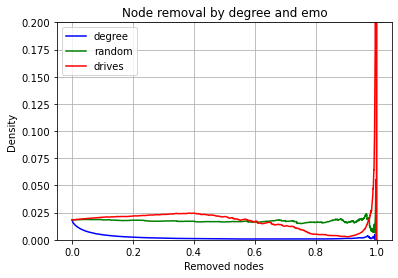

In [199]:
'''
max_numb_iter = min([len(x_e), len(x_d),len(x_r)])
    

density_d_arr = np.array(y_d)[:max_numb_iter]
density_e_arr = np.array(y_e)[:max_numb_iter]
density_r_arr = np.array(y_r)[:max_numb_iter]

x= np.array(x_d)/max_numb_iter
    
plt.plot(x[:max_numb_iter], density_d_arr, 'b-', label = 'degree')
plt.plot(x[:max_numb_iter], density_r_arr, 'g-', label = 'random')
plt.plot(x[:max_numb_iter], density_e_arr, 'r-', label = emo)
    
plt.title("Node removal by "+'degree and emo')
plt.ylabel("Density")
plt.xlabel("Removed nodes")
plt.ylim(0,0.2)
plt.legend()
plt.grid 
'''

In [215]:
#file= "../prova_robustness/china1"

In [16]:
def compute_centrality(g,mode='degree'):
    if mode == 'degree' :
        nodes_degrees = nx.degree_centrality(g)
    elif mode == 'closeness':   
        nodes_degrees = nx.closeness_centrality(g)
    elif mode == 'betweenness' :
        nodes_degrees = nx.betweenness_centrality(g)
    else : 
        print("aborted, error in compute_centrality")
        return
        

    max_centrality = max(nodes_degrees, key=nodes_degrees.get)
    #print('\n\tNode with Max number of Edges: ', max_centrality,
    #      ' ||' + str(mode), nodes_degrees[max_centrality])#, file=file)

    return max_centrality, nodes_degrees


In [ ]:
'''
def graph_robustness(g,plotOn = True,diametersOn = False, plotDiametersOn = False):   #diameter take a lot of time
    length= len(g.nodes())
    g_remove_most_important = g.copy()
    list_components = []
    list_removed = []
    list_removed2 = [n+100 for n in range(0,len(g_remove_most_important.nodes() )-200,200 )   ]
    list_diameters = []
    list_diameters_number = []
    list_diameters_max = []
    list_diameters_min = []
    list_giantcomponentnodes = []
    
    
    print("::: Computing Degree :::")
    for x in range(length):
        best_node, nodes = compute_centrality(g_remove_most_important,mode = 'degree')
        #comps = list(nx.connected_component_subgraphs(g_remove_most_important))
        
        comps=list( (g_remove_most_important.subgraph(c) for c in nx.connected_components(g_remove_most_important)) )
        giant_comp = max(comps, key=len)
        comp_nodes_number = giant_comp.number_of_nodes()
        comp_len = len(comps)

        if x in list_removed2:
            print('----- Nodes removed: ', x, ' -----')
            if diametersOn:
                diameters = [nx.diameter(comp) for comp in comps]
                list_diameters_max.append(max(diameters))
                list_diameters_min.append(min(diameters))
                list_diameters.append(sum(diameters) / len(diameters))
                list_diameters_number.append(x)

                if plotDiametersOn and x == 1000:
                    degree = dict(giant_comp.degree())
                    plot_distribution(degree.values(), 'degree')

            list_giantcomponentnodes.append(comp_nodes_number)
        
        list_components.append(comp_len)
        list_removed.append(x)

        g_remove_most_important.remove_nodes_from([best_node])


    g_remove_most_important = g.copy()
    list_components2 = []
    list_giantcomponentnodes2 = []
    list_diameters2 = []
    list_diameters_number2 = []
    list_diameters_max2 = []
    list_diameters_min2 = []

    print("::: Computing Closeness :::")
    lent=len(list_removed2)
    for x in range(lent):
        print('----- Nodes removed: ', x, ' -----')
        best_node, nodes = compute_centrality(g_remove_most_important,mode = 'closeness')
        first_nodes = heapq.nlargest(200, nodes, key=nodes.get)
        comps=list( (g_remove_most_important.subgraph(c) for c in nx.connected_components(g_remove_most_important)) )

        comp_len = len(comps)
        giant_comp = max(comps, key=len)
        comp_nodes_number = giant_comp.number_of_nodes()

        if diametersOn:
            diameters = [nx.diameter(comp) for comp in comps]
            list_diameters_max2.append(max(diameters))
            list_diameters_min2.append(min(diameters))
            list_diameters2.append(sum(diameters) / len(diameters))
            list_diameters_number2.append(x)

            
        list_giantcomponentnodes2.append(comp_nodes_number)
        list_components2.append(comp_len)

        g_remove_most_important.remove_nodes_from(first_nodes)

    
    g_remove_most_important = g.copy()
    list_components3 = []
    list_giantcomponentnodes3 = []
    list_diameters3 = []
    list_diameters_number3 = []
    list_diameters_max3 = []
    list_diameters_min3 = []

    print("::: Computing Betweenness :::")
    for x in range(lent):
        print('----- Nodes removed: ', x, ' -----')
        best_node, nodes = compute_centrality(g_remove_most_important,mode = 'betweenness')
        first_nodes = heapq.nlargest(200, nodes, key=nodes.get)
        comps=list( (g_remove_most_important.subgraph(c) for c in nx.connected_components(g_remove_most_important)) )
        comp_len = len(comps)
        giant_comp = max(comps, key=len)
        comp_nodes_number = giant_comp.number_of_nodes()

        if diametersOn:
            diameters = [nx.diameter(comp) for comp in comps]
            list_diameters_max3.append(max(diameters))
            list_diameters_min3.append(min(diameters))
            list_diameters3.append(sum(diameters) / len(diameters))
            list_diameters_number3.append(x)

            if plotDiametersOn and x == 10:
                degree = dict(giant_comp.degree())
                plot_distribution(degree.values(), 'degree')

        list_giantcomponentnodes3.append(comp_nodes_number)
        list_components3.append(comp_len)

        g_remove_most_important.remove_nodes_from(first_nodes)


    if plotOn:
        print("::: Plotting :::")
        # Plot of different centrality algo
        plt.plot(list_removed, list_components, 'r-')
        plt.plot(list_removed2, list_components2, 'b-')
        plt.plot(list_removed2, list_components3, 'g-')
        plt.ylabel("Components number")
        plt.xlabel("Removed nodes")
        plt.legend(['Degree', 'Closeness', 'Betweenness'], loc='lower right')
        #plt.savefig('data/' + 'centralitiescomponents' + '.png', dpi=500)
        plt.show()

        # Plot of Giant Component nodes number
        plt.plot(list_diameters_number, list_giantcomponentnodes, 'r-')
        plt.plot(list_removed2, list_giantcomponentnodes2, 'b-')
        plt.plot(list_removed2, list_giantcomponentnodes3, 'g-')
        plt.ylabel("Giant Component number of nodes")
        plt.xlabel("Removed nodes")
        plt.legend(['Degree', 'Closeness', 'Betweenness'], loc='upper right')
        #plt.savefig('data/' + 'giantcomponents' + '.png', dpi=500)
        plt.show()
        if diametersOn:
            # Plot of degree diameters
            plt.plot(list_removed2, list_diameters_max, 'r-')
            plt.plot(list_removed2, list_diameters_min, 'b-')
            plt.plot(list_removed2, list_diameters, 'g-')
            plt.ylabel("Diameter")
            plt.xlabel("Removed nodes")
            plt.legend(['Max', 'Min', 'Average'], loc='upper right')
            #plt.savefig('data/' + 'diagram_degree' + '.png', dpi=500)
            plt.show()

            # Plot of closeness diameters
            plt.plot(list_removed2, list_diameters_max2, 'r-')
            plt.plot(list_removed2, list_diameters_min2, 'b-')
            plt.plot(list_removed2, list_diameters2, 'g-')
            plt.ylabel("Diameter")
            plt.xlabel("Removed nodes")
            plt.legend(['Max', 'Min', 'Average'], loc='upper right')
            #plt.savefig('data/' + 'diagram_closeness' + '.png', dpi=500)
            plt.show()

            # Plot of betweenness diameters
            plt.plot(list_removed2, list_diameters_max3, 'r-')
            plt.plot(list_removed2, list_diameters_min3, 'b-')
            plt.plot(list_removed2, list_diameters3, 'g-')
            plt.ylabel("Diameter")
            plt.xlabel("Removed nodes")
            plt.legend(['Max', 'Min', 'Average'], loc='upper right')
            #plt.savefig('data/' + 'diagram_betweenness' + '.png', dpi=500)
            plt.show()

        # Plot of giant + components
        plt.plot(list_removed, list_components, 'r-')
        plt.plot(list_removed2, list_components2, 'b-')
        plt.plot(list_removed2, list_components3, 'g-')

        plt.plot(list_removed2, list_giantcomponentnodes, 'c-')
        plt.plot(list_removed2, list_giantcomponentnodes2, 'm-')
        plt.plot(list_removed2, list_giantcomponentnodes3, 'y-')

        plt.ylabel("Components number and Giant Component number of nodes")
        plt.xlabel("Removed nodes")
        plt.legend(['Degree', 'Closeness', 'Betweenness', 'Degree_Giant', 'Closeness_Giant', 'Betweenness_Giant'],
                   loc='upper right')
        #plt.savefig('data/' + 'centralities_and_giant' + '.png', dpi=500)
        plt.show()
        
'''

In [28]:
def graph_robustness(g,plotOn = True):   #diameter take a lot of time
    length= len(g.nodes())
    g_remove_most_important = g.copy()
    list_components = []
    list_removed = []
    list_removed2 = [n+100 for n in range(0,len(g_remove_most_important.nodes() )-200,100 )   ]
    list_giantcomponentnodes = []
    
    
    print("::: Computing Degree :::")
    for x in range(length):
        best_node, nodes = compute_centrality(g_remove_most_important,mode = 'degree')
        #comps = list(nx.connected_component_subgraphs(g_remove_most_important))
        
        comps=list( (g_remove_most_important.subgraph(c) for c in nx.connected_components(g_remove_most_important)) )
        giant_comp = max(comps, key=len)
        comp_nodes_number = giant_comp.number_of_nodes()
        comp_len = len(comps)

        if x in list_removed2:
            print('----- Nodes removed: ', x, ' -----')

            list_giantcomponentnodes.append(comp_nodes_number)
        
        list_components.append(comp_len)
        list_removed.append(x)

        g_remove_most_important.remove_nodes_from([best_node])


    g_remove_most_important = g.copy()
    list_components2 = []
    list_giantcomponentnodes2 = []


    print("::: Computing Closeness :::")
    lent=len(list_removed2)
    dim=int(length/lent)
    for x in range(lent):
        print('----- Nodes removed: ', x, ' -----')
        best_node, nodes = compute_centrality(g_remove_most_important,mode = 'closeness')
        first_nodes = heapq.nlargest(dim, nodes, key=nodes.get)
        comps=list( (g_remove_most_important.subgraph(c) for c in nx.connected_components(g_remove_most_important)) )

        comp_len = len(comps)
        giant_comp = max(comps, key=len)
        comp_nodes_number = giant_comp.number_of_nodes()
            
        list_giantcomponentnodes2.append(comp_nodes_number)
        list_components2.append(comp_len)

        g_remove_most_important.remove_nodes_from(first_nodes)

    
    g_remove_most_important = g.copy()
    list_components3 = []
    list_giantcomponentnodes3 = []
    

    print("::: Computing Betweenness :::")
    for x in range(lent):
        print('----- Nodes removed: ', x, ' -----')
        best_node, nodes = compute_centrality(g_remove_most_important,mode = 'betweenness')
        first_nodes = heapq.nlargest(dim, nodes, key=nodes.get)
        comps=list( (g_remove_most_important.subgraph(c) for c in nx.connected_components(g_remove_most_important)) )
        comp_len = len(comps)
        giant_comp = max(comps, key=len)
        comp_nodes_number = giant_comp.number_of_nodes()

        
        list_giantcomponentnodes3.append(comp_nodes_number)
        list_components3.append(comp_len)

        g_remove_most_important.remove_nodes_from(first_nodes)


    if plotOn:
        print("::: Plotting :::")
        # Plot of different centrality algo
        plt.plot(list_removed, list_components, 'r-')
        plt.plot(list_removed2, list_components2, 'b-')
        plt.plot(list_removed2, list_components3, 'g-')
        plt.ylabel("Components number")
        plt.xlabel("Removed nodes")
        plt.legend(['Degree', 'Closeness', 'Betweenness'], loc='lower right')
        #plt.savefig('data/' + 'centralitiescomponents' + '.png', dpi=500)
        plt.show()

        # Plot of Giant Component nodes number
        plt.plot(list_removed2, list_giantcomponentnodes, 'r-')
        plt.plot(list_removed2, list_giantcomponentnodes2, 'b-')
        plt.plot(list_removed2, list_giantcomponentnodes3, 'g-')
        plt.ylabel("Giant Component number of nodes")
        plt.xlabel("Removed nodes")
        plt.legend(['Degree', 'Closeness', 'Betweenness'], loc='upper right')
        #plt.savefig('data/' + 'giantcomponents' + '.png', dpi=500)
        plt.show()
        

        # Plot of giant + components
        plt.plot(list_removed, list_components, 'r-')
        plt.plot(list_removed2, list_components2, 'b-')
        plt.plot(list_removed2, list_components3, 'g-')

        plt.plot(list_removed2, list_giantcomponentnodes, 'c-')
        plt.plot(list_removed2, list_giantcomponentnodes2, 'm-')
        plt.plot(list_removed2, list_giantcomponentnodes3, 'y-')

        plt.ylabel("Number")
        plt.xlabel("Removed nodes")
        plt.title("Components number and Giant Component number of nodes")
        plt.legend(['Degree', 'Closeness', 'Betweenness', 'Degree_Giant', 'Closeness_Giant', 'Betweenness_Giant'],
                   loc='upper right')
        #plt.savefig('data/' + 'centralities_and_giant' + '.png', dpi=500)
        plt.show()

::: Computing Degree :::
----- Nodes removed:  100  -----
----- Nodes removed:  200  -----
----- Nodes removed:  300  -----
----- Nodes removed:  400  -----
----- Nodes removed:  500  -----
----- Nodes removed:  600  -----
----- Nodes removed:  700  -----
----- Nodes removed:  800  -----
----- Nodes removed:  900  -----
----- Nodes removed:  1000  -----
----- Nodes removed:  1100  -----
----- Nodes removed:  1200  -----
----- Nodes removed:  1300  -----
----- Nodes removed:  1400  -----
----- Nodes removed:  1500  -----
----- Nodes removed:  1600  -----
----- Nodes removed:  1700  -----
----- Nodes removed:  1800  -----
----- Nodes removed:  1900  -----
----- Nodes removed:  2000  -----
----- Nodes removed:  2100  -----
----- Nodes removed:  2200  -----
----- Nodes removed:  2300  -----
----- Nodes removed:  2400  -----
----- Nodes removed:  2500  -----
----- Nodes removed:  2600  -----
----- Nodes removed:  2700  -----
----- Nodes removed:  2800  -----
----- Nodes removed:  2900  ----

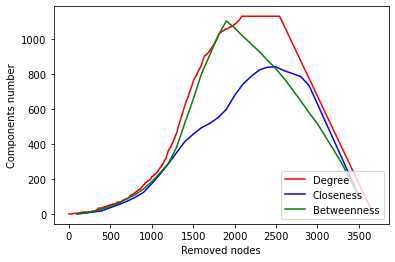

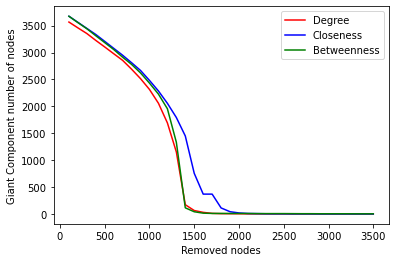

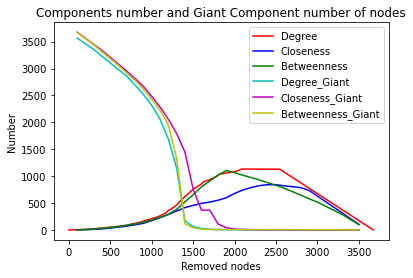

In [29]:
graph_robustness(C1)

::: Computing Degree :::
----- Nodes removed:  100  -----
----- Nodes removed:  200  -----
----- Nodes removed:  300  -----
----- Nodes removed:  400  -----
----- Nodes removed:  500  -----
----- Nodes removed:  600  -----
----- Nodes removed:  700  -----
----- Nodes removed:  800  -----
----- Nodes removed:  900  -----
----- Nodes removed:  1000  -----
----- Nodes removed:  1100  -----
----- Nodes removed:  1200  -----
----- Nodes removed:  1300  -----
----- Nodes removed:  1400  -----
----- Nodes removed:  1500  -----
----- Nodes removed:  1600  -----
----- Nodes removed:  1700  -----
----- Nodes removed:  1800  -----
----- Nodes removed:  1900  -----
----- Nodes removed:  2000  -----
----- Nodes removed:  2100  -----
----- Nodes removed:  2200  -----
----- Nodes removed:  2300  -----
----- Nodes removed:  2400  -----
----- Nodes removed:  2500  -----
----- Nodes removed:  2600  -----
----- Nodes removed:  2700  -----
----- Nodes removed:  2800  -----
----- Nodes removed:  2900  ----

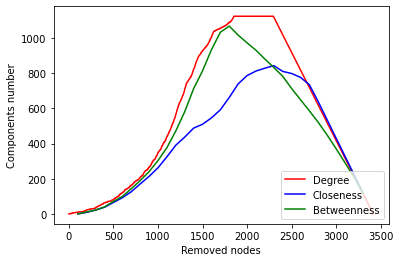

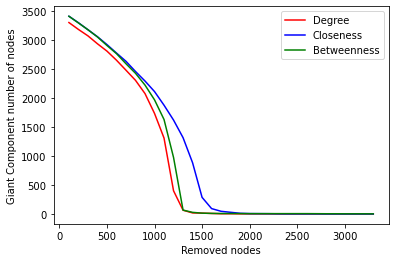

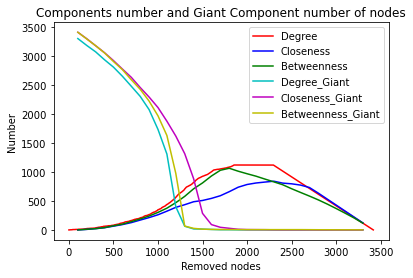

In [30]:
graph_robustness(A1)

::: Computing Degree :::
----- Nodes removed:  100  -----
----- Nodes removed:  200  -----
----- Nodes removed:  300  -----
----- Nodes removed:  400  -----
----- Nodes removed:  500  -----
----- Nodes removed:  600  -----
----- Nodes removed:  700  -----
----- Nodes removed:  800  -----
----- Nodes removed:  900  -----
----- Nodes removed:  1000  -----
----- Nodes removed:  1100  -----
----- Nodes removed:  1200  -----
----- Nodes removed:  1300  -----
----- Nodes removed:  1400  -----
----- Nodes removed:  1500  -----
----- Nodes removed:  1600  -----
----- Nodes removed:  1700  -----
----- Nodes removed:  1800  -----
----- Nodes removed:  1900  -----
----- Nodes removed:  2000  -----
----- Nodes removed:  2100  -----
----- Nodes removed:  2200  -----
----- Nodes removed:  2300  -----
----- Nodes removed:  2400  -----
----- Nodes removed:  2500  -----
----- Nodes removed:  2600  -----
----- Nodes removed:  2700  -----
----- Nodes removed:  2800  -----
----- Nodes removed:  2900  ----

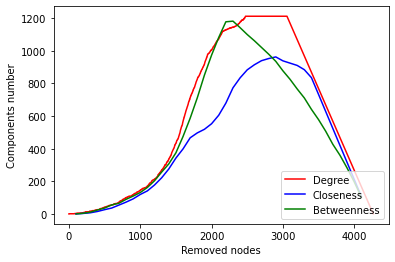

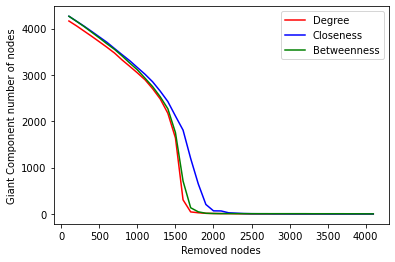

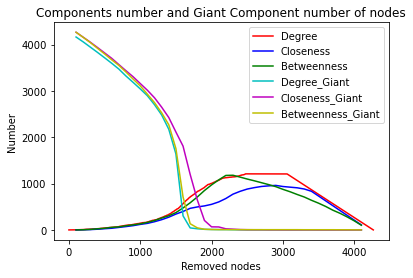

In [31]:
graph_robustness(C2)

::: Computing Degree :::
----- Nodes removed:  100  -----
----- Nodes removed:  200  -----
----- Nodes removed:  300  -----
----- Nodes removed:  400  -----
----- Nodes removed:  500  -----
----- Nodes removed:  600  -----
----- Nodes removed:  700  -----
----- Nodes removed:  800  -----
----- Nodes removed:  900  -----
----- Nodes removed:  1000  -----
----- Nodes removed:  1100  -----
----- Nodes removed:  1200  -----
----- Nodes removed:  1300  -----
----- Nodes removed:  1400  -----
----- Nodes removed:  1500  -----
----- Nodes removed:  1600  -----
----- Nodes removed:  1700  -----
----- Nodes removed:  1800  -----
----- Nodes removed:  1900  -----
----- Nodes removed:  2000  -----
----- Nodes removed:  2100  -----
----- Nodes removed:  2200  -----
----- Nodes removed:  2300  -----
----- Nodes removed:  2400  -----
----- Nodes removed:  2500  -----
----- Nodes removed:  2600  -----
----- Nodes removed:  2700  -----
----- Nodes removed:  2800  -----
----- Nodes removed:  2900  ----

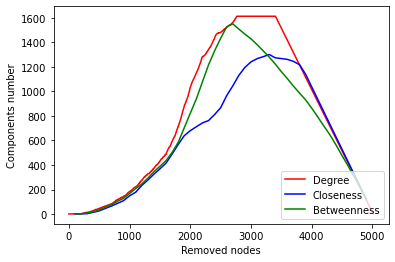

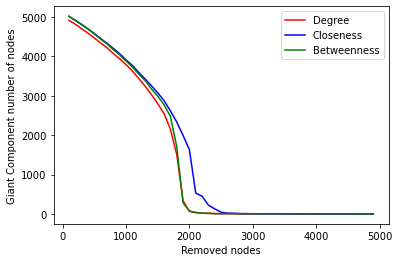

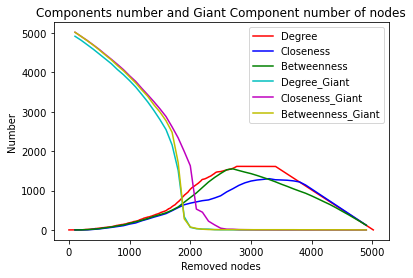

In [32]:
graph_robustness(A2)

::: Computing Degree :::
----- Nodes removed:  100  -----
----- Nodes removed:  200  -----
----- Nodes removed:  300  -----
----- Nodes removed:  400  -----
----- Nodes removed:  500  -----
----- Nodes removed:  600  -----
----- Nodes removed:  700  -----
----- Nodes removed:  800  -----
----- Nodes removed:  900  -----
----- Nodes removed:  1000  -----
----- Nodes removed:  1100  -----
----- Nodes removed:  1200  -----
----- Nodes removed:  1300  -----
----- Nodes removed:  1400  -----
----- Nodes removed:  1500  -----
----- Nodes removed:  1600  -----
----- Nodes removed:  1700  -----
----- Nodes removed:  1800  -----
----- Nodes removed:  1900  -----
----- Nodes removed:  2000  -----
----- Nodes removed:  2100  -----
----- Nodes removed:  2200  -----
----- Nodes removed:  2300  -----
----- Nodes removed:  2400  -----
----- Nodes removed:  2500  -----
----- Nodes removed:  2600  -----
----- Nodes removed:  2700  -----
----- Nodes removed:  2800  -----
----- Nodes removed:  2900  ----

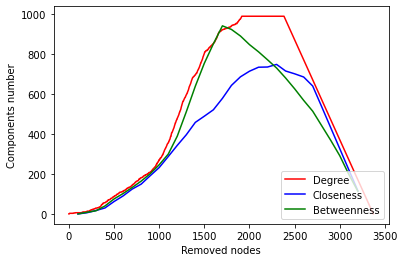

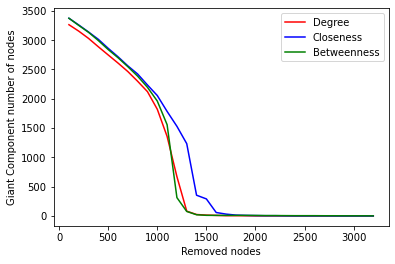

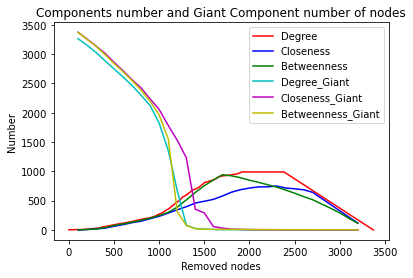

In [33]:
graph_robustness(A3)

::: Computing Degree :::
----- Nodes removed:  100  -----
----- Nodes removed:  200  -----
----- Nodes removed:  300  -----
----- Nodes removed:  400  -----
----- Nodes removed:  500  -----
----- Nodes removed:  600  -----
----- Nodes removed:  700  -----
----- Nodes removed:  800  -----
----- Nodes removed:  900  -----
----- Nodes removed:  1000  -----
----- Nodes removed:  1100  -----
----- Nodes removed:  1200  -----
----- Nodes removed:  1300  -----
----- Nodes removed:  1400  -----
----- Nodes removed:  1500  -----
----- Nodes removed:  1600  -----
----- Nodes removed:  1700  -----
----- Nodes removed:  1800  -----
----- Nodes removed:  1900  -----
::: Computing Closeness :::
----- Nodes removed:  0  -----
----- Nodes removed:  1  -----
----- Nodes removed:  2  -----
----- Nodes removed:  3  -----
----- Nodes removed:  4  -----
----- Nodes removed:  5  -----
----- Nodes removed:  6  -----
----- Nodes removed:  7  -----
----- Nodes removed:  8  -----
----- Nodes removed:  9  -----


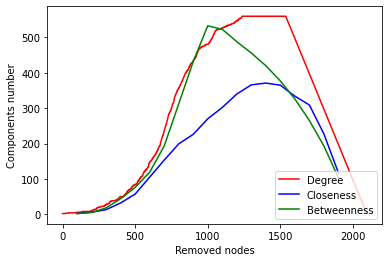

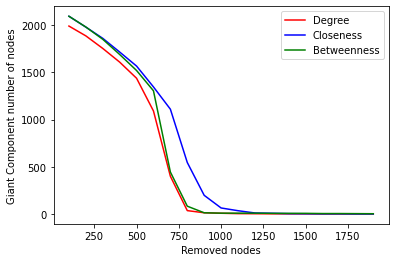

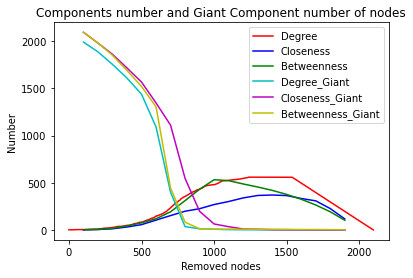

In [34]:
graph_robustness(C3)

In [301]:
'''
def graph_robustness_random_dg(g,plotOn = True,diametersOn = False, plotDiametersOn = False):   #diameter take a lot of time
    nodes =list(g.nodes() )
    length= len(nodes)
    g_remove_most_important = g.copy()
    list_components = []
    list_removed = []
    list_removed2 = [n+100 for n in range(0,length-100,300 )   ]
    list_diameters = []
    list_diameters_number = []
    list_diameters_max = []
    list_diameters_min = []
    list_giantcomponentnodes = []
    
    
    print("::: Computing Degree :::")
    for x in range(length):
        best_node, _ = compute_centrality(g_remove_most_important,mode = 'degree')
        #comps = list(nx.connected_component_subgraphs(g_remove_most_important))
        
        comps=list( (g_remove_most_important.subgraph(c) for c in nx.connected_components(g_remove_most_important)) )
        giant_comp = max(comps, key=len)
        comp_nodes_number = giant_comp.number_of_nodes()
        comp_len = len(comps)

        if x in list_removed2:
            print('----- Nodes removed: ', x, ' -----')
            if diametersOn:
                diameters = [nx.diameter(comp) for comp in comps]
                list_diameters_max.append(max(diameters))
                list_diameters_min.append(min(diameters))
                list_diameters.append(sum(diameters) / len(diameters))
                list_diameters_number.append(x)

                if plotDiametersOn and x == 1000:
                    degree = dict(giant_comp.degree())
                    plot_distribution(degree.values(), 'degree')

            list_giantcomponentnodes.append(comp_nodes_number)
        
        list_components.append(comp_len)
        list_removed.append(x)

        g_remove_most_important.remove_nodes_from([best_node])
    
    
    g_remove_most_important = g.copy()
    list_components2 = []
    list_giantcomponentnodes2 = []
    list_diameters2 = []
    list_diameters_number2 = []
    list_diameters_max2 = []
    list_diameters_min2 = []

    print("::: Computing for random :::")
    for x in range(length):
        #best_node, nodes = compute_centrality(g_remove_most_important,mode = 'degree')
        #comps = list(nx.connected_component_subgraphs(g_remove_most_important))
        nodes =list(g_remove_most_important.nodes() )
        random_node = random.choice(nodes)
        comps=list( (g_remove_most_important.subgraph(c) for c in nx.connected_components(g_remove_most_important)) )
        giant_comp = max(comps, key=len)
        comp_nodes_number = giant_comp.number_of_nodes()
        comp_len = len(comps)

        if x in list_removed2:
            print('----- Nodes removed: ', x, ' -----')
            if diametersOn:
                diameters = [nx.diameter(comp) for comp in comps]
                list_diameters_max2.append(max(diameters))
                list_diameters_min2.append(min(diameters))
                list_diameters2.append(sum(diameters) / len(diameters))
                list_diameters_number2.append(x)

                if plotDiametersOn and x == 1000:
                    degree = dict(giant_comp.degree())
                    plot_distribution(degree.values(), 'degree')

            list_giantcomponentnodes2.append(comp_nodes_number)
        
        list_components2.append(comp_len)
        g_remove_most_important.remove_nodes_from([random_node])


    if plotOn:
        print("::: Plotting :::")
        # Plot of different centrality algo
        plt.plot(list_removed, list_components, 'r-')
        plt.plot(list_removed, list_components2, 'b-')
        #plt.plot(list_removed2, list_components3, 'g-')
        plt.ylabel("Components number")
        plt.xlabel("Removed nodes")
        plt.legend(['Degree', 'random'], loc='lower right')
        #plt.savefig('data/' + 'centralitiescomponents' + '.png', dpi=500)
        plt.show()

        # Plot of Giant Component nodes number
        plt.plot(list_removed2, list_giantcomponentnodes, 'r-')
        plt.plot(list_removed2, list_giantcomponentnodes2, 'b-')
        #plt.plot(list_removed2, list_giantcomponentnodes3, 'g-')
        plt.ylabel("Giant Component number of nodes")
        plt.xlabel("Removed nodes")
        plt.legend(['Degree', 'random'], loc='upper right')
        #plt.savefig('data/' + 'giantcomponents' + '.png', dpi=500)
        plt.show()
        if diametersOn:
            # Plot of degree diameters
            plt.plot(list_removed2, list_diameters_max, 'r-')
            plt.plot(list_removed2, list_diameters_min, 'b-')
            plt.plot(list_removed2, list_diameters, 'g-')
            plt.ylabel("Diameter")
            plt.xlabel("Removed nodes")
            plt.legend(['Max', 'Min', 'Average'], loc='upper right')
            #plt.savefig('data/' + 'diagram_degree' + '.png', dpi=500)
            plt.show()

            # Plot of random diameters
            plt.plot(list_removed2, list_diameters_max2, 'r-')
            plt.plot(list_removed2, list_diameters_min2, 'b-')
            plt.plot(list_removed2, list_diameters2, 'g-')
            plt.ylabel("Diameter")
            plt.xlabel("Removed nodes")
            plt.legend(['Max', 'Min', 'Average'], loc='upper right')
            #plt.savefig('data/' + 'diagram_closeness' + '.png', dpi=500)
            plt.show()

        # Plot of betweenness diameters
        #plt.plot(list_removed2, list_diameters_max3, 'r-')
        #plt.plot(list_removed2, list_diameters_min3, 'b-')
        #plt.plot(list_removed2, list_diameters3, 'g-')
        #plt.ylabel("Diameter")
        #plt.xlabel("Removed nodes")
        #plt.legend(['Max', 'Min', 'Average'], loc='upper right')
        #plt.savefig('data/' + 'diagram_betweenness' + '.png', dpi=500)
        #plt.show()

        # Plot of giant + components
        plt.plot(list_removed, list_components, 'r-')
        plt.plot(list_removed, list_components2, 'b-')
        #plt.plot(list_removed2, list_components3, 'g-')

        plt.plot(list_removed2, list_giantcomponentnodes, 'c-')
        plt.plot(list_removed2, list_giantcomponentnodes2, 'm-')
        #plt.plot(list_removed2, list_giantcomponentnodes3, 'y-')

        plt.ylabel("Components number and Giant Component number of nodes")
        plt.xlabel("Removed nodes")
        plt.legend(['Degree', 'random', 'Degree_Giant', 'random_Giant'],
                   loc='upper right')
        #plt.savefig('data/' + 'centralities_and_giant' + '.png', dpi=500)
        plt.show()
'''

In [89]:
def graph_robustness_random_emo(g,emo='negemo',emo2='posemo',plotOn = True):   #diameter take a lot of time
    nodes =list(g.nodes() )
    length= len(nodes)
    g_remove_most_important = g.copy()
    list_components = []
    list_removed = []
    list_removed2 = [n+100 for n in range(0,length-100,100 )   ]
    list_giantcomponentnodes = []

    
    
    print("::: Computing Degree :::")
    for x in range(length):
        best_node, _ = compute_centrality(g_remove_most_important,mode = 'degree')
        #comps = list(nx.connected_component_subgraphs(g_remove_most_important))
        
        comps=list( (g_remove_most_important.subgraph(c) for c in nx.connected_components(g_remove_most_important)) )
        giant_comp = max(comps, key=len)
        comp_nodes_number = giant_comp.number_of_nodes()
        comp_len = len(comps)

        if x in list_removed2:
            print('----- Nodes removed: ', x, ' -----')
            list_giantcomponentnodes.append(comp_nodes_number)
        
        list_components.append(comp_len)
        list_removed.append(x)

        g_remove_most_important.remove_nodes_from([best_node])
    
    g_remove_most_important = g.copy()
    list_components2 = []
    list_giantcomponentnodes2 = []

    print("::: Computing for random :::")
    for x in range(length):
        #best_node, nodes = compute_centrality(g_remove_most_important,mode = 'degree')
        #comps = list(nx.connected_component_subgraphs(g_remove_most_important))
        nodes =list(g_remove_most_important.nodes() )
        random_node = random.choice(nodes)
        comps=list( (g_remove_most_important.subgraph(c) for c in nx.connected_components(g_remove_most_important)) )
        giant_comp = max(comps, key=len)
        comp_nodes_number = giant_comp.number_of_nodes()
        comp_len = len(comps)

        if x in list_removed2:
            print('----- Nodes removed: ', x, ' -----')
            list_giantcomponentnodes2.append(comp_nodes_number)
        
        list_components2.append(comp_len)
        g_remove_most_important.remove_nodes_from([random_node])
        
    print(f"::: Computing for {emo} :::")
    #mw is a dict:
    g_remove_most_important = g.copy()
    list_components3 = []
    list_giantcomponentnodes3 = []
    
    Emo_index_dict_n   = nx.get_node_attributes(g,emo)
    sorted_Emo_index_n = sorted(Emo_index_dict_n.items(), key=itemgetter(1), reverse=True)
    nodes_to_remove_emo     = [x[0] for x in sorted_Emo_index_n if x[1] < 120.0]
    
    #nodes_to_remove_emo =[selected_Emo_n[i] for i,v in enumerate(selected_Emo_n)]
    for x in range(length):
        #best_node, nodes = compute_centrality(g_remove_most_important,mode = 'degree')
        #comps = list(nx.connected_component_subgraphs(g_remove_most_important))
        emo_node = nodes_to_remove_emo[x]
        comps=list( (g_remove_most_important.subgraph(c) for c in nx.connected_components(g_remove_most_important)) )
        giant_comp = max(comps, key=len)
        comp_nodes_number = giant_comp.number_of_nodes()
        comp_len = len(comps)

        if x in list_removed2:
            print('----- Nodes removed: ', x, ' -----')
            list_giantcomponentnodes3.append(comp_nodes_number)
        
        list_components3.append(comp_len)
        g_remove_most_important.remove_nodes_from([emo_node])
    
    print(f"::: Computing for {emo2} :::")
    #mw is a dict:
    g_remove_most_important = g.copy()
    list_components4 = []
    list_giantcomponentnodes4 = []
    
    Emo_index_dict_n   = nx.get_node_attributes(g,emo2)
    sorted_Emo_index_n = sorted(Emo_index_dict_n.items(), key=itemgetter(1), reverse=True)
    nodes_to_remove_emo     = [x[0] for x in sorted_Emo_index_n if x[1] < 120.0]
    
    #nodes_to_remove_emo =[selected_Emo_n[i] for i,v in enumerate(selected_Emo_n)]
    for x in range(length):
        #best_node, nodes = compute_centrality(g_remove_most_important,mode = 'degree')
        #comps = list(nx.connected_component_subgraphs(g_remove_most_important))
        emo_node = nodes_to_remove_emo[x]
        comps=list( (g_remove_most_important.subgraph(c) for c in nx.connected_components(g_remove_most_important)) )
        giant_comp = max(comps, key=len)
        comp_nodes_number = giant_comp.number_of_nodes()
        comp_len = len(comps)

        if x in list_removed2:
            print('----- Nodes removed: ', x, ' -----')
            list_giantcomponentnodes4.append(comp_nodes_number)
        
        list_components4.append(comp_len)
        g_remove_most_important.remove_nodes_from([emo_node])


    if plotOn:
        print("::: Plotting :::")
        # Plot of different centrality algo
        plt.plot(list_removed, list_components, 'r-')
        plt.plot(list_removed, list_components2, 'b-')
        plt.plot(list_removed, list_components3, 'g-')
        plt.plot(list_removed, list_components4, 'y-')

        plt.ylabel("Components number")
        plt.xlabel("Removed nodes")
        plt.legend(['Degree', 'random',emo,emo2], loc='lower right')
        #plt.savefig('data/' + 'centralitiescomponents' + '.png', dpi=500)
        plt.show()

        # Plot of Giant Component nodes number
        plt.plot(list_removed2, list_giantcomponentnodes, 'r-')
        plt.plot(list_removed2, list_giantcomponentnodes2, 'b-')
        plt.plot(list_removed2, list_giantcomponentnodes3, 'g-')
        plt.plot(list_removed2, list_giantcomponentnodes4, 'y-')
        
        plt.ylabel("Giant Component number of nodes")
        plt.xlabel("Removed nodes")
        plt.legend(['Degree', 'random', emo,emo2], loc='upper right')
        #plt.savefig('data/' + 'giantcomponents' + '.png', dpi=500)
        plt.show()
        

        # Plot of giant + components
        plt.plot(list_removed, list_components, '-')
        plt.plot(list_removed, list_components2, 'g--')
        plt.plot(list_removed, list_components3, 'b-')
        plt.plot(list_removed, list_components4, 'r-')

        plt.plot(list_removed2, list_giantcomponentnodes, '-')
        plt.plot(list_removed2, list_giantcomponentnodes2, 'y--')
        plt.plot(list_removed2, list_giantcomponentnodes3, 'c-')
        plt.plot(list_removed2, list_giantcomponentnodes4, 'm-')


        plt.ylabel("Number")
        plt.xlabel("Removed nodes")
        plt.title("Components number and Giant Component number of nodes")
        plt.legend(['Degree', 'random', emo,emo2, 'Degree_Giant', 'random_Giant', str("Giant_"+emo), str("Giant_"+emo2)],
                   loc='upper right')
        #plt.savefig('data/' + 'centralities_and_giant' + '.png', dpi=500)
        plt.show()

## posemo-negemo

::: Computing Degree :::
----- Nodes removed:  100  -----
----- Nodes removed:  200  -----
----- Nodes removed:  300  -----
----- Nodes removed:  400  -----
----- Nodes removed:  500  -----
----- Nodes removed:  600  -----
----- Nodes removed:  700  -----
----- Nodes removed:  800  -----
----- Nodes removed:  900  -----
----- Nodes removed:  1000  -----
----- Nodes removed:  1100  -----
----- Nodes removed:  1200  -----
----- Nodes removed:  1300  -----
----- Nodes removed:  1400  -----
----- Nodes removed:  1500  -----
----- Nodes removed:  1600  -----
----- Nodes removed:  1700  -----
----- Nodes removed:  1800  -----
----- Nodes removed:  1900  -----
----- Nodes removed:  2000  -----
----- Nodes removed:  2100  -----
----- Nodes removed:  2200  -----
----- Nodes removed:  2300  -----
----- Nodes removed:  2400  -----
----- Nodes removed:  2500  -----
----- Nodes removed:  2600  -----
----- Nodes removed:  2700  -----
::: Computing for random :::
----- Nodes removed:  100  -----
----

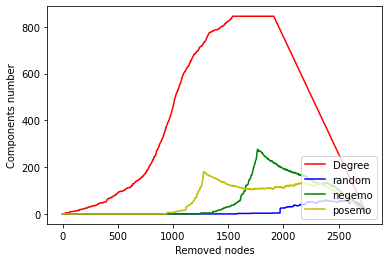

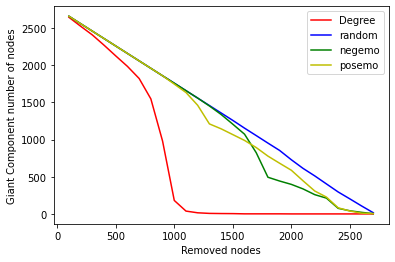

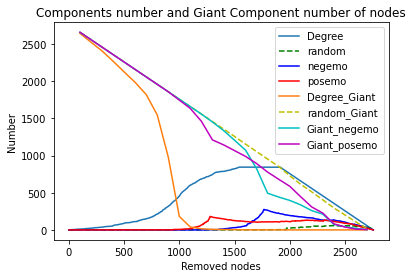

In [90]:
graph_robustness_random_emo(A1)

::: Computing Degree :::
----- Nodes removed:  100  -----
----- Nodes removed:  200  -----
----- Nodes removed:  300  -----
----- Nodes removed:  400  -----
----- Nodes removed:  500  -----
----- Nodes removed:  600  -----
----- Nodes removed:  700  -----
----- Nodes removed:  800  -----
----- Nodes removed:  900  -----
----- Nodes removed:  1000  -----
----- Nodes removed:  1100  -----
----- Nodes removed:  1200  -----
----- Nodes removed:  1300  -----
----- Nodes removed:  1400  -----
----- Nodes removed:  1500  -----
----- Nodes removed:  1600  -----
----- Nodes removed:  1700  -----
----- Nodes removed:  1800  -----
----- Nodes removed:  1900  -----
----- Nodes removed:  2000  -----
----- Nodes removed:  2100  -----
----- Nodes removed:  2200  -----
----- Nodes removed:  2300  -----
----- Nodes removed:  2400  -----
----- Nodes removed:  2500  -----
----- Nodes removed:  2600  -----
----- Nodes removed:  2700  -----
----- Nodes removed:  2800  -----
----- Nodes removed:  2900  ----

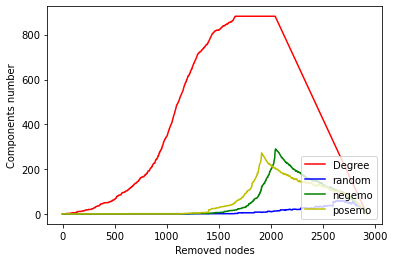

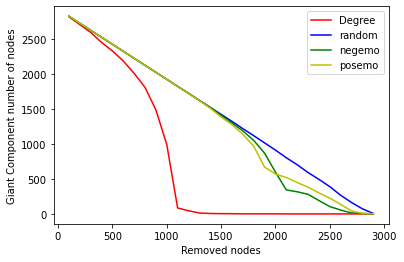

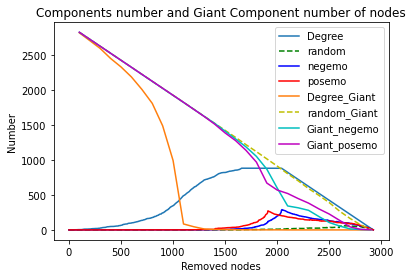

In [91]:
graph_robustness_random_emo(C1)

::: Computing Degree :::
----- Nodes removed:  100  -----
----- Nodes removed:  200  -----
----- Nodes removed:  300  -----
----- Nodes removed:  400  -----
----- Nodes removed:  500  -----
----- Nodes removed:  600  -----
----- Nodes removed:  700  -----
----- Nodes removed:  800  -----
----- Nodes removed:  900  -----
----- Nodes removed:  1000  -----
----- Nodes removed:  1100  -----
----- Nodes removed:  1200  -----
----- Nodes removed:  1300  -----
----- Nodes removed:  1400  -----
----- Nodes removed:  1500  -----
----- Nodes removed:  1600  -----
----- Nodes removed:  1700  -----
----- Nodes removed:  1800  -----
----- Nodes removed:  1900  -----
----- Nodes removed:  2000  -----
----- Nodes removed:  2100  -----
----- Nodes removed:  2200  -----
----- Nodes removed:  2300  -----
----- Nodes removed:  2400  -----
----- Nodes removed:  2500  -----
----- Nodes removed:  2600  -----
----- Nodes removed:  2700  -----
----- Nodes removed:  2800  -----
----- Nodes removed:  2900  ----

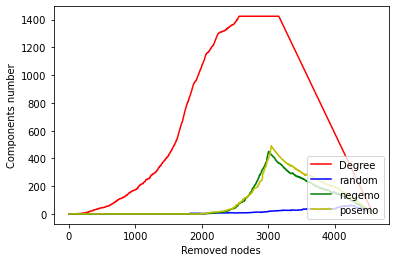

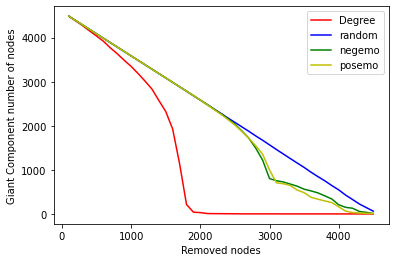

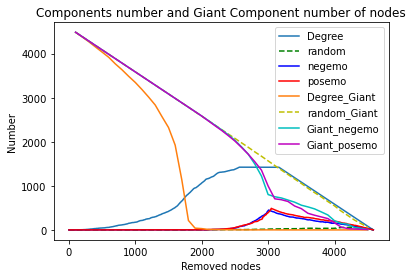

In [92]:
graph_robustness_random_emo(A2)

::: Computing Degree :::
----- Nodes removed:  100  -----
----- Nodes removed:  200  -----
----- Nodes removed:  300  -----
----- Nodes removed:  400  -----
----- Nodes removed:  500  -----
----- Nodes removed:  600  -----
----- Nodes removed:  700  -----
----- Nodes removed:  800  -----
----- Nodes removed:  900  -----
----- Nodes removed:  1000  -----
----- Nodes removed:  1100  -----
----- Nodes removed:  1200  -----
----- Nodes removed:  1300  -----
----- Nodes removed:  1400  -----
----- Nodes removed:  1500  -----
----- Nodes removed:  1600  -----
----- Nodes removed:  1700  -----
----- Nodes removed:  1800  -----
----- Nodes removed:  1900  -----
----- Nodes removed:  2000  -----
----- Nodes removed:  2100  -----
----- Nodes removed:  2200  -----
::: Computing for random :::
----- Nodes removed:  100  -----
----- Nodes removed:  200  -----
----- Nodes removed:  300  -----
----- Nodes removed:  400  -----
----- Nodes removed:  500  -----
----- Nodes removed:  600  -----
----- Nod

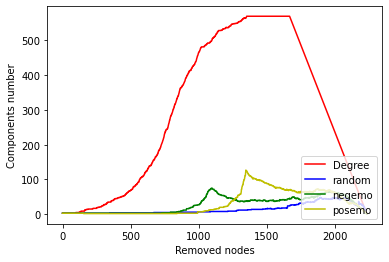

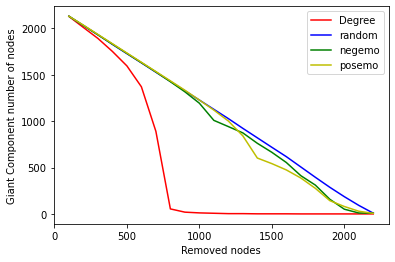

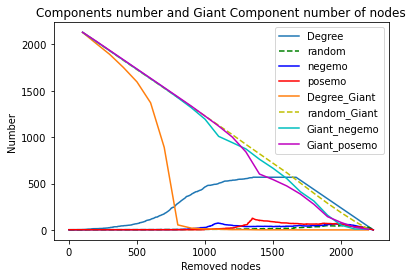

In [93]:
graph_robustness_random_emo(C2)

::: Computing Degree :::
----- Nodes removed:  100  -----
----- Nodes removed:  200  -----
----- Nodes removed:  300  -----
----- Nodes removed:  400  -----
----- Nodes removed:  500  -----
----- Nodes removed:  600  -----
----- Nodes removed:  700  -----
----- Nodes removed:  800  -----
----- Nodes removed:  900  -----
----- Nodes removed:  1000  -----
----- Nodes removed:  1100  -----
----- Nodes removed:  1200  -----
----- Nodes removed:  1300  -----
----- Nodes removed:  1400  -----
----- Nodes removed:  1500  -----
----- Nodes removed:  1600  -----
----- Nodes removed:  1700  -----
----- Nodes removed:  1800  -----
----- Nodes removed:  1900  -----
----- Nodes removed:  2000  -----
----- Nodes removed:  2100  -----
----- Nodes removed:  2200  -----
----- Nodes removed:  2300  -----
----- Nodes removed:  2400  -----
----- Nodes removed:  2500  -----
----- Nodes removed:  2600  -----
----- Nodes removed:  2700  -----
----- Nodes removed:  2800  -----
----- Nodes removed:  2900  ----

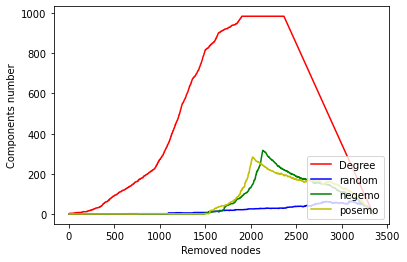

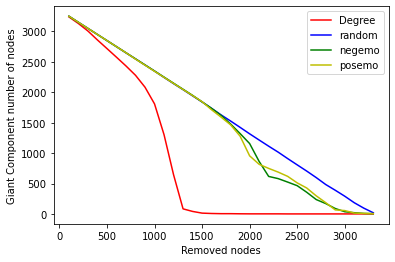

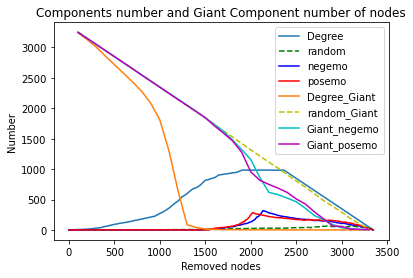

In [94]:
graph_robustness_random_emo(A3)

::: Computing Degree :::
----- Nodes removed:  100  -----
----- Nodes removed:  200  -----
----- Nodes removed:  300  -----
----- Nodes removed:  400  -----
----- Nodes removed:  500  -----
----- Nodes removed:  600  -----
----- Nodes removed:  700  -----
----- Nodes removed:  800  -----
----- Nodes removed:  900  -----
----- Nodes removed:  1000  -----
----- Nodes removed:  1100  -----
----- Nodes removed:  1200  -----
----- Nodes removed:  1300  -----
----- Nodes removed:  1400  -----
----- Nodes removed:  1500  -----
----- Nodes removed:  1600  -----
----- Nodes removed:  1700  -----
----- Nodes removed:  1800  -----
----- Nodes removed:  1900  -----
::: Computing for random :::
----- Nodes removed:  100  -----
----- Nodes removed:  200  -----
----- Nodes removed:  300  -----
----- Nodes removed:  400  -----
----- Nodes removed:  500  -----
----- Nodes removed:  600  -----
----- Nodes removed:  700  -----
----- Nodes removed:  800  -----
----- Nodes removed:  900  -----
----- Nodes 

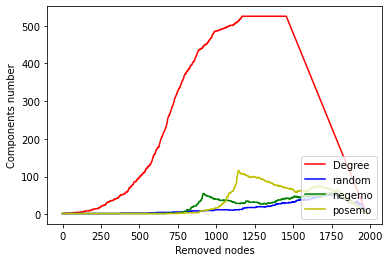

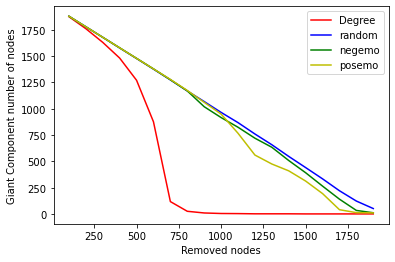

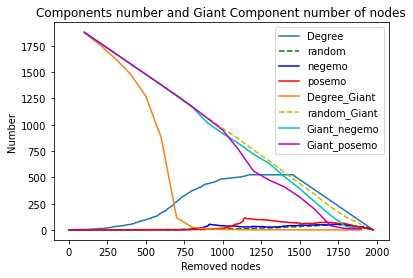

In [95]:
graph_robustness_random_emo(C3)

## death-they

::: Computing Degree :::
----- Nodes removed:  100  -----
----- Nodes removed:  200  -----
----- Nodes removed:  300  -----
----- Nodes removed:  400  -----
----- Nodes removed:  500  -----
----- Nodes removed:  600  -----
----- Nodes removed:  700  -----
----- Nodes removed:  800  -----
----- Nodes removed:  900  -----
----- Nodes removed:  1000  -----
----- Nodes removed:  1100  -----
----- Nodes removed:  1200  -----
----- Nodes removed:  1300  -----
----- Nodes removed:  1400  -----
----- Nodes removed:  1500  -----
----- Nodes removed:  1600  -----
----- Nodes removed:  1700  -----
----- Nodes removed:  1800  -----
----- Nodes removed:  1900  -----
----- Nodes removed:  2000  -----
----- Nodes removed:  2100  -----
----- Nodes removed:  2200  -----
----- Nodes removed:  2300  -----
----- Nodes removed:  2400  -----
----- Nodes removed:  2500  -----
----- Nodes removed:  2600  -----
----- Nodes removed:  2700  -----
::: Computing for random :::
----- Nodes removed:  100  -----
----

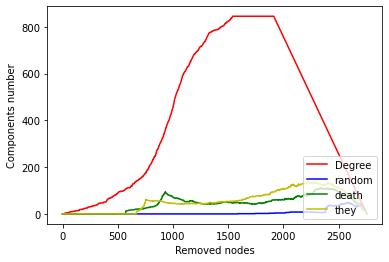

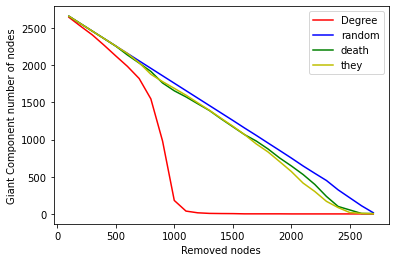

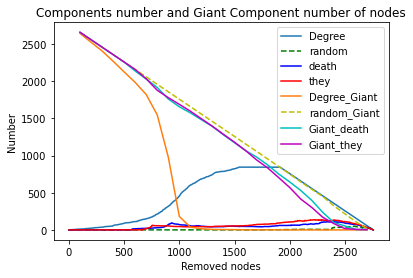

In [99]:
graph_robustness_random_emo(A1,emo="death",emo2="they")

graph_robustness_random_emo(C1,emo="death",emo="they")

::: Computing Degree :::
----- Nodes removed:  100  -----
----- Nodes removed:  200  -----
----- Nodes removed:  300  -----
----- Nodes removed:  400  -----
----- Nodes removed:  500  -----
----- Nodes removed:  600  -----
----- Nodes removed:  700  -----
----- Nodes removed:  800  -----
----- Nodes removed:  900  -----
----- Nodes removed:  1000  -----
----- Nodes removed:  1100  -----
----- Nodes removed:  1200  -----
----- Nodes removed:  1300  -----
----- Nodes removed:  1400  -----
----- Nodes removed:  1500  -----
----- Nodes removed:  1600  -----
----- Nodes removed:  1700  -----
----- Nodes removed:  1800  -----
----- Nodes removed:  1900  -----
----- Nodes removed:  2000  -----
----- Nodes removed:  2100  -----
----- Nodes removed:  2200  -----
----- Nodes removed:  2300  -----
----- Nodes removed:  2400  -----
----- Nodes removed:  2500  -----
----- Nodes removed:  2600  -----
----- Nodes removed:  2700  -----
----- Nodes removed:  2800  -----
----- Nodes removed:  2900  ----

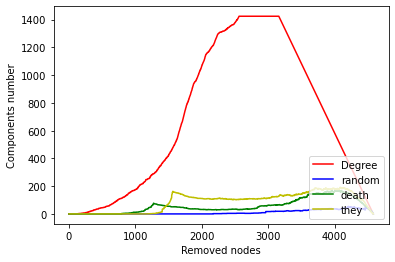

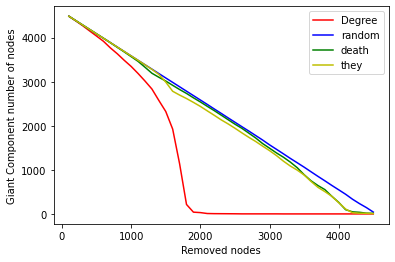

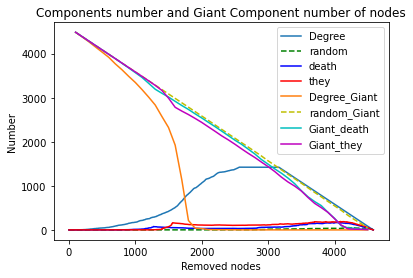

In [100]:
graph_robustness_random_emo(A2,emo="death",emo2="they")

::: Computing Degree :::
----- Nodes removed:  100  -----
----- Nodes removed:  200  -----
----- Nodes removed:  300  -----
----- Nodes removed:  400  -----
----- Nodes removed:  500  -----
----- Nodes removed:  600  -----
----- Nodes removed:  700  -----
----- Nodes removed:  800  -----
----- Nodes removed:  900  -----
----- Nodes removed:  1000  -----
----- Nodes removed:  1100  -----
----- Nodes removed:  1200  -----
----- Nodes removed:  1300  -----
----- Nodes removed:  1400  -----
----- Nodes removed:  1500  -----
----- Nodes removed:  1600  -----
----- Nodes removed:  1700  -----
----- Nodes removed:  1800  -----
----- Nodes removed:  1900  -----
----- Nodes removed:  2000  -----
----- Nodes removed:  2100  -----
----- Nodes removed:  2200  -----
::: Computing for random :::
----- Nodes removed:  100  -----
----- Nodes removed:  200  -----
----- Nodes removed:  300  -----
----- Nodes removed:  400  -----
----- Nodes removed:  500  -----
----- Nodes removed:  600  -----
----- Nod

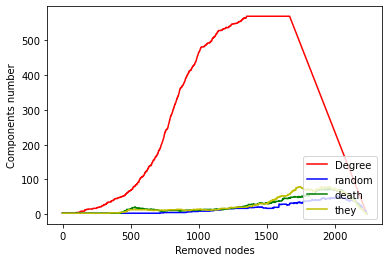

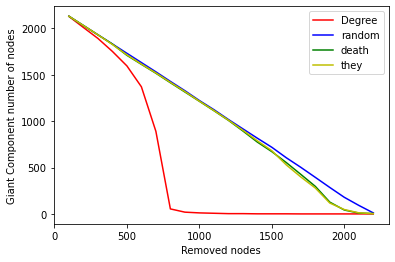

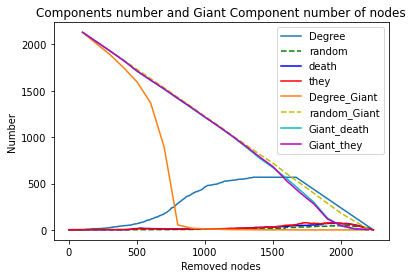

In [101]:
graph_robustness_random_emo(C2,emo="death",emo2="they")

::: Computing Degree :::
----- Nodes removed:  100  -----
----- Nodes removed:  200  -----
----- Nodes removed:  300  -----
----- Nodes removed:  400  -----
----- Nodes removed:  500  -----
----- Nodes removed:  600  -----
----- Nodes removed:  700  -----
----- Nodes removed:  800  -----
----- Nodes removed:  900  -----
----- Nodes removed:  1000  -----
----- Nodes removed:  1100  -----
----- Nodes removed:  1200  -----
----- Nodes removed:  1300  -----
----- Nodes removed:  1400  -----
----- Nodes removed:  1500  -----
----- Nodes removed:  1600  -----
----- Nodes removed:  1700  -----
----- Nodes removed:  1800  -----
----- Nodes removed:  1900  -----
----- Nodes removed:  2000  -----
----- Nodes removed:  2100  -----
----- Nodes removed:  2200  -----
----- Nodes removed:  2300  -----
----- Nodes removed:  2400  -----
----- Nodes removed:  2500  -----
----- Nodes removed:  2600  -----
----- Nodes removed:  2700  -----
----- Nodes removed:  2800  -----
----- Nodes removed:  2900  ----

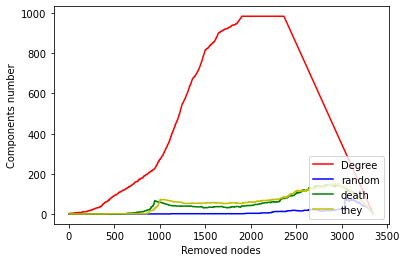

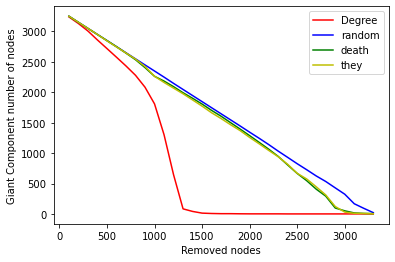

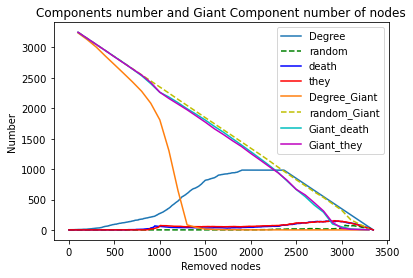

In [102]:
graph_robustness_random_emo(A3,emo="death",emo2="they")

::: Computing Degree :::
----- Nodes removed:  100  -----
----- Nodes removed:  200  -----
----- Nodes removed:  300  -----
----- Nodes removed:  400  -----
----- Nodes removed:  500  -----
----- Nodes removed:  600  -----
----- Nodes removed:  700  -----
----- Nodes removed:  800  -----
----- Nodes removed:  900  -----
----- Nodes removed:  1000  -----
----- Nodes removed:  1100  -----
----- Nodes removed:  1200  -----
----- Nodes removed:  1300  -----
----- Nodes removed:  1400  -----
----- Nodes removed:  1500  -----
----- Nodes removed:  1600  -----
----- Nodes removed:  1700  -----
----- Nodes removed:  1800  -----
----- Nodes removed:  1900  -----
::: Computing for random :::
----- Nodes removed:  100  -----
----- Nodes removed:  200  -----
----- Nodes removed:  300  -----
----- Nodes removed:  400  -----
----- Nodes removed:  500  -----
----- Nodes removed:  600  -----
----- Nodes removed:  700  -----
----- Nodes removed:  800  -----
----- Nodes removed:  900  -----
----- Nodes 

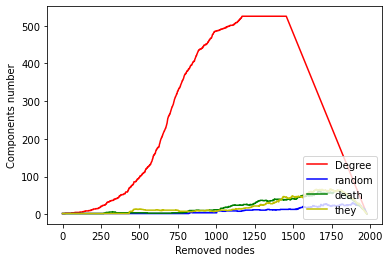

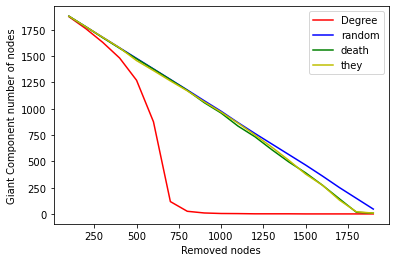

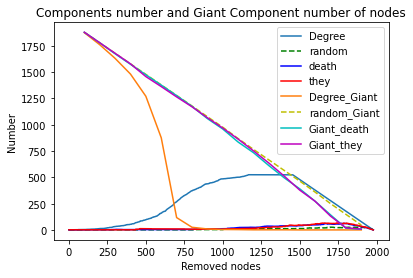

In [103]:
graph_robustness_random_emo(C3,emo="death",emo2="they")

::: Computing Degree :::
----- Nodes removed:  100  -----
----- Nodes removed:  200  -----
----- Nodes removed:  300  -----
----- Nodes removed:  400  -----
----- Nodes removed:  500  -----
----- Nodes removed:  600  -----
----- Nodes removed:  700  -----
----- Nodes removed:  800  -----
----- Nodes removed:  900  -----
----- Nodes removed:  1000  -----
----- Nodes removed:  1100  -----
----- Nodes removed:  1200  -----
----- Nodes removed:  1300  -----
----- Nodes removed:  1400  -----
----- Nodes removed:  1500  -----
----- Nodes removed:  1600  -----
----- Nodes removed:  1700  -----
----- Nodes removed:  1800  -----
----- Nodes removed:  1900  -----
----- Nodes removed:  2000  -----
----- Nodes removed:  2100  -----
----- Nodes removed:  2200  -----
----- Nodes removed:  2300  -----
----- Nodes removed:  2400  -----
----- Nodes removed:  2500  -----
----- Nodes removed:  2600  -----
----- Nodes removed:  2700  -----
----- Nodes removed:  2800  -----
----- Nodes removed:  2900  ----

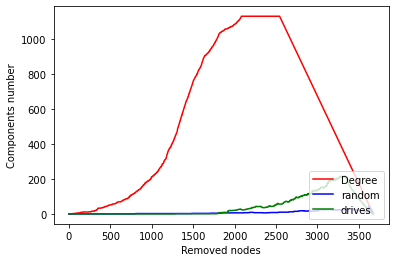

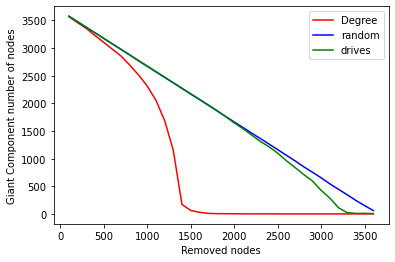

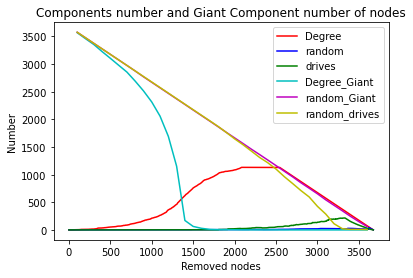

In [63]:
graph_robustness_random_emo(C1,emo)

::: Computing Degree :::
----- Nodes removed:  100  -----
----- Nodes removed:  200  -----
----- Nodes removed:  300  -----
----- Nodes removed:  400  -----
----- Nodes removed:  500  -----
----- Nodes removed:  600  -----
----- Nodes removed:  700  -----
----- Nodes removed:  800  -----
----- Nodes removed:  900  -----
----- Nodes removed:  1000  -----
----- Nodes removed:  1100  -----
----- Nodes removed:  1200  -----
----- Nodes removed:  1300  -----
----- Nodes removed:  1400  -----
----- Nodes removed:  1500  -----
----- Nodes removed:  1600  -----
----- Nodes removed:  1700  -----
----- Nodes removed:  1800  -----
----- Nodes removed:  1900  -----
----- Nodes removed:  2000  -----
----- Nodes removed:  2100  -----
----- Nodes removed:  2200  -----
----- Nodes removed:  2300  -----
----- Nodes removed:  2400  -----
----- Nodes removed:  2500  -----
----- Nodes removed:  2600  -----
----- Nodes removed:  2700  -----
----- Nodes removed:  2800  -----
----- Nodes removed:  2900  ----

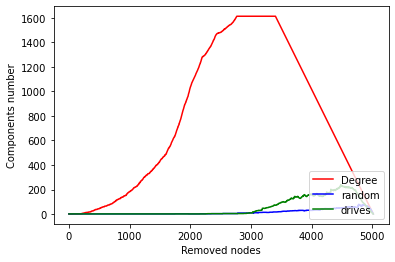

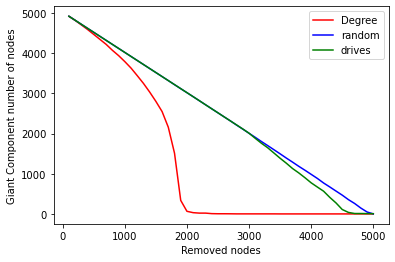

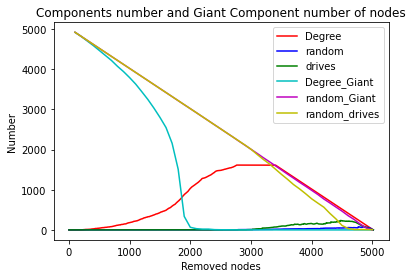

In [64]:
graph_robustness_random_emo(A2,emo)

::: Computing Degree :::
----- Nodes removed:  100  -----
----- Nodes removed:  200  -----
----- Nodes removed:  300  -----
----- Nodes removed:  400  -----
----- Nodes removed:  500  -----
----- Nodes removed:  600  -----
----- Nodes removed:  700  -----
----- Nodes removed:  800  -----
----- Nodes removed:  900  -----
----- Nodes removed:  1000  -----
----- Nodes removed:  1100  -----
----- Nodes removed:  1200  -----
----- Nodes removed:  1300  -----
----- Nodes removed:  1400  -----
----- Nodes removed:  1500  -----
----- Nodes removed:  1600  -----
----- Nodes removed:  1700  -----
----- Nodes removed:  1800  -----
----- Nodes removed:  1900  -----
----- Nodes removed:  2000  -----
::: Computing for random :::
----- Nodes removed:  100  -----
----- Nodes removed:  200  -----
----- Nodes removed:  300  -----
----- Nodes removed:  400  -----
----- Nodes removed:  500  -----
----- Nodes removed:  600  -----
----- Nodes removed:  700  -----
----- Nodes removed:  800  -----
----- Nodes

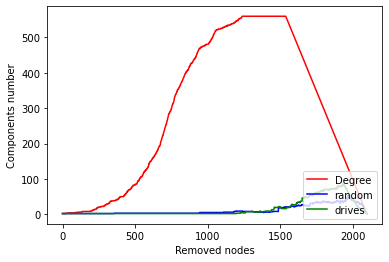

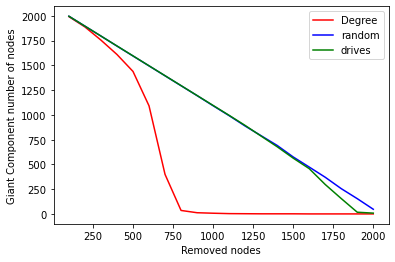

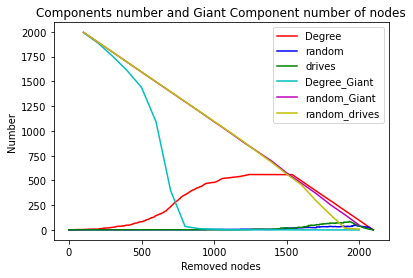

In [65]:
graph_robustness_random_emo(C3,emo)

::: Computing Degree :::
----- Nodes removed:  100  -----
----- Nodes removed:  200  -----
----- Nodes removed:  300  -----
----- Nodes removed:  400  -----
----- Nodes removed:  500  -----
----- Nodes removed:  600  -----
----- Nodes removed:  700  -----
----- Nodes removed:  800  -----
----- Nodes removed:  900  -----
----- Nodes removed:  1000  -----
----- Nodes removed:  1100  -----
----- Nodes removed:  1200  -----
----- Nodes removed:  1300  -----
----- Nodes removed:  1400  -----
----- Nodes removed:  1500  -----
----- Nodes removed:  1600  -----
----- Nodes removed:  1700  -----
----- Nodes removed:  1800  -----
----- Nodes removed:  1900  -----
----- Nodes removed:  2000  -----
----- Nodes removed:  2100  -----
----- Nodes removed:  2200  -----
----- Nodes removed:  2300  -----
----- Nodes removed:  2400  -----
----- Nodes removed:  2500  -----
----- Nodes removed:  2600  -----
----- Nodes removed:  2700  -----
----- Nodes removed:  2800  -----
----- Nodes removed:  2900  ----

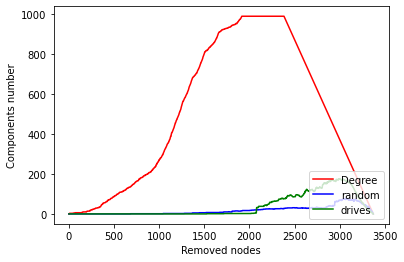

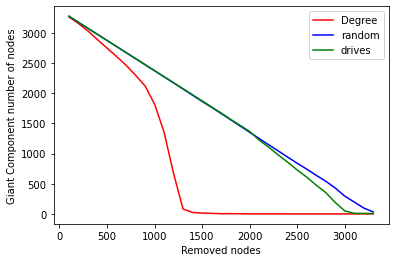

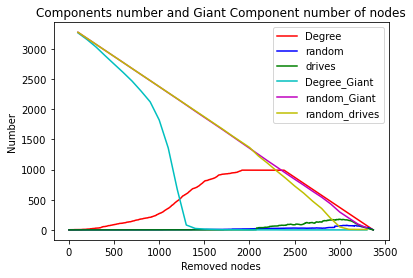

In [66]:
graph_robustness_random_emo(A3,emo)

::: Computing Degree :::
----- Nodes removed:  100  -----
----- Nodes removed:  200  -----
----- Nodes removed:  300  -----
----- Nodes removed:  400  -----
----- Nodes removed:  500  -----
----- Nodes removed:  600  -----
----- Nodes removed:  700  -----
----- Nodes removed:  800  -----
----- Nodes removed:  900  -----
----- Nodes removed:  1000  -----
----- Nodes removed:  1100  -----
----- Nodes removed:  1200  -----
----- Nodes removed:  1300  -----
----- Nodes removed:  1400  -----
----- Nodes removed:  1500  -----
----- Nodes removed:  1600  -----
----- Nodes removed:  1700  -----
----- Nodes removed:  1800  -----
----- Nodes removed:  1900  -----
----- Nodes removed:  2000  -----
----- Nodes removed:  2100  -----
----- Nodes removed:  2200  -----
----- Nodes removed:  2300  -----
----- Nodes removed:  2400  -----
----- Nodes removed:  2500  -----
----- Nodes removed:  2600  -----
----- Nodes removed:  2700  -----
----- Nodes removed:  2800  -----
----- Nodes removed:  2900  ----

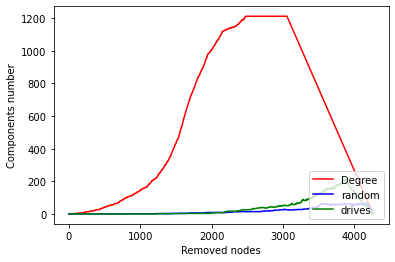

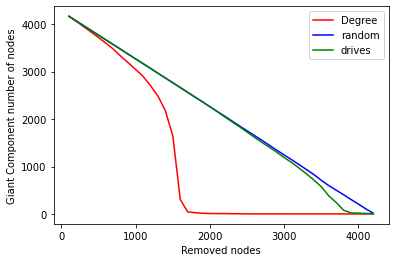

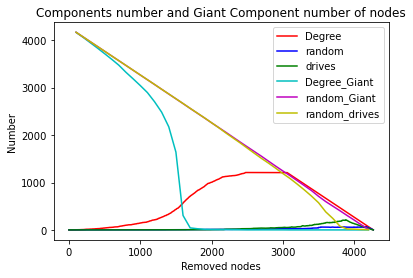

In [67]:
graph_robustness_random_emo(C2,emo)

# NODE REMOVAL WITH LIWK RESULT

In [148]:
def graph_robustness_random_emos(g,emos,plotOn = True):   #diameter take a lot of time
    nodes =list(g.nodes() )
    length= len(nodes)
    g_remove_most_important = g.copy()
    list_components = []
    list_removed = []
    list_removed2 = [n+1 for n in range(0,length-2,1 )   ]
    list_giantcomponentnodes = []

    g_remove_most_important = g.copy()
    list_components2 = []
    list_giantcomponentnodes2 = []

    print("::: Computing for random :::")
    for x in range(length):
        #best_node, nodes = compute_centrality(g_remove_most_important,mode = 'degree')
        #comps = list(nx.connected_component_subgraphs(g_remove_most_important))
        nodes =list(g_remove_most_important.nodes() )
        random_node = random.choice(nodes)
        comps=list( (g_remove_most_important.subgraph(c) for c in nx.connected_components(g_remove_most_important)) )
        giant_comp = max(comps, key=len)
        comp_nodes_number = giant_comp.number_of_nodes()
        comp_len = len(comps)
        list_removed.append(x)

        if x in list_removed2:
            #print('----- Nodes removed: ', x, ' -----')
            list_giantcomponentnodes2.append(comp_nodes_number)
        
        list_components2.append(comp_len)
        g_remove_most_important.remove_nodes_from([random_node])
    
    list_components_emo=[]
    list_giantcomponentnodes_emo=[]
    
    for emo in emos:
        print(f"::: Computing for {emo} :::")
        #mw is a dict:
        g_remove_most_important = g.copy()
        list_components3 = []
        list_giantcomponentnodes3 = []

        Emo_index_dict_n   = nx.get_node_attributes(g,emo)
        sorted_Emo_index_n = sorted(Emo_index_dict_n.items(), key=itemgetter(1), reverse=True)
        nodes_to_remove_emo     = [x[0] for x in sorted_Emo_index_n if x[1] < 120.0]

        #nodes_to_remove_emo =[selected_Emo_n[i] for i,v in enumerate(selected_Emo_n)]
        for x in range(length):
            #best_node, nodes = compute_centrality(g_remove_most_important,mode = 'degree')
            #comps = list(nx.connected_component_subgraphs(g_remove_most_important))
            emo_node = nodes_to_remove_emo[x]
            comps=list( (g_remove_most_important.subgraph(c) for c in nx.connected_components(g_remove_most_important)) )
            giant_comp = max(comps, key=len)
            comp_nodes_number = giant_comp.number_of_nodes()
            comp_len = len(comps)

            if x in list_removed2:
                #if x%1000 :print('----- Nodes removed: ', x, ' -----')
                list_giantcomponentnodes3.append(comp_nodes_number)

            list_components3.append(comp_len)
            g_remove_most_important.remove_nodes_from([emo_node])
        
        list_components_emo.append(list_components3)
        list_giantcomponentnodes_emo.append(list_giantcomponentnodes3)
    

    if plotOn:
        lg=[ 'random']
        print("::: Plotting :::")
        # Plot of different centrality algo
        plt.plot(list_removed, list_components2, 'b-')
        for i in range(len(emos)):
            plt.plot(list_removed, list_components_emo[i], '-')
            lg.append(emos[i])

        plt.ylabel("Components number")
        plt.xlabel("Removed nodes")
        plt.legend(lg,bbox_to_anchor=(1.04,1))
        #plt.savefig('data/' + 'centralitiescomponents' + '.png', dpi=500)
        plt.show()
        
        lg.append('random_Giant')
        lg2=['random_Giant']
        # Plot of Giant Component nodes number
        plt.plot(list_removed2, list_giantcomponentnodes2, 'b-')
        for i in range(len(emos)):
            plt.plot(list_removed2, list_giantcomponentnodes_emo[i], '-')
            lg.append(str("Giant_"+emos[i]))
            lg2.append(str("Giant_"+emos[i]))
            
        
        plt.ylabel("Giant Component number of nodes")
        plt.xlabel("Removed nodes")
        plt.legend(lg2 ,bbox_to_anchor=(1.04,1))
        #plt.savefig('data/' + 'giantcomponents' + '.png', dpi=500)
        plt.show()
        

        # Plot of giant + components
        plt.plot(list_removed, list_components2, 'g--')
        
        for i in range(len(emos)):
            plt.plot(list_removed, list_components_emo[i], '-')
        
        plt.plot(list_removed2, list_giantcomponentnodes2, 'y--')
        for i in range(len(emos)):
            plt.plot(list_removed2, list_giantcomponentnodes_emo[i], '-')    
        

        plt.ylabel("Number")
        plt.xlabel("Removed nodes")
        plt.title("Components number and Giant Component number of nodes")
        plt.legend(lg ,bbox_to_anchor=(1.04,1))
        #plt.savefig('data/' + 'centralities_and_giant' + '.png', dpi=500)
        plt.tight_layout
        plt.show()

::: Computing for random :::
::: Computing for negemo :::
::: Computing for posemo :::
::: Computing for they :::
::: Computing for we :::
::: Computing for focuspast :::
::: Computing for focusfuture :::
::: Computing for focuspresent :::
::: Plotting :::


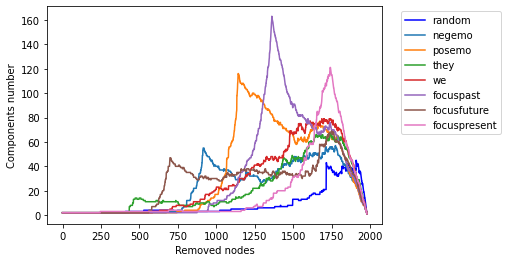

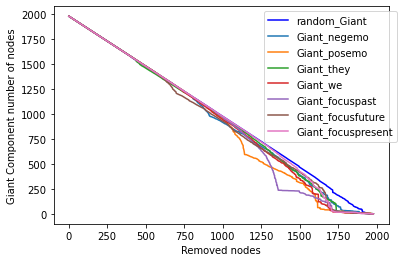

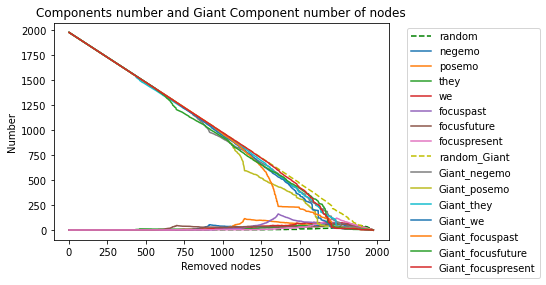

In [149]:
graph_robustness_random_emos(C3,emos)

::: Computing for random :::
::: Computing for negemo :::
::: Computing for posemo :::
::: Computing for they :::
::: Computing for we :::
::: Computing for focuspast :::
::: Computing for focusfuture :::
::: Computing for focuspresent :::
::: Plotting :::


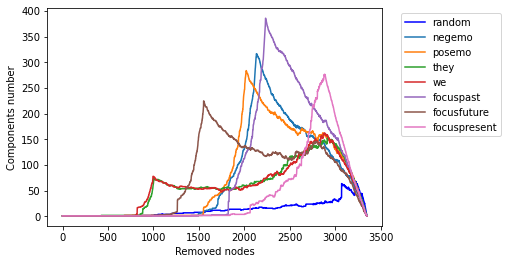

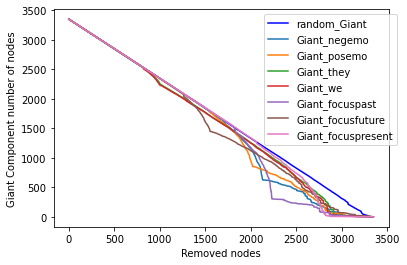

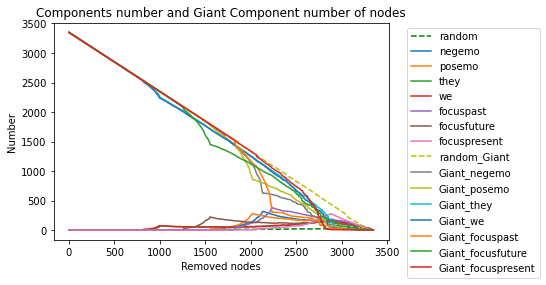

In [150]:
graph_robustness_random_emos(A3,emos)

::: Computing for random :::
::: Computing for negemo :::
::: Computing for posemo :::
::: Computing for they :::
::: Computing for we :::
::: Computing for focuspast :::
::: Computing for focusfuture :::
::: Computing for focuspresent :::
::: Plotting :::


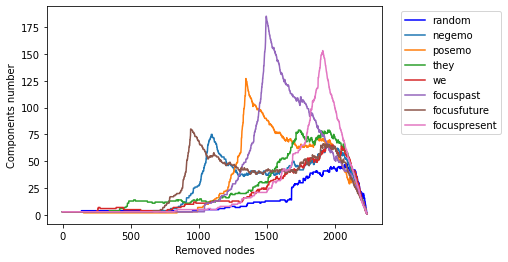

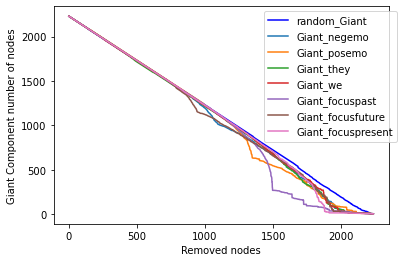

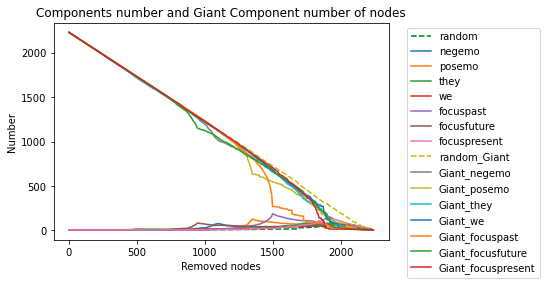

In [151]:
graph_robustness_random_emos(C2,emos)

::: Computing for random :::
::: Computing for negemo :::
::: Computing for posemo :::
::: Computing for they :::
::: Computing for we :::
::: Computing for focuspast :::
::: Computing for focusfuture :::
::: Computing for focuspresent :::
::: Plotting :::


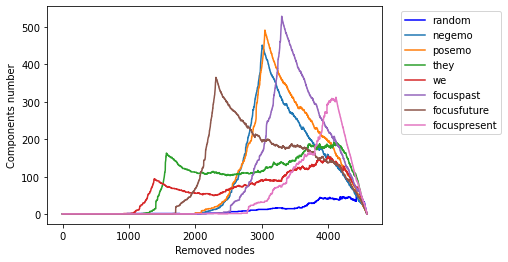

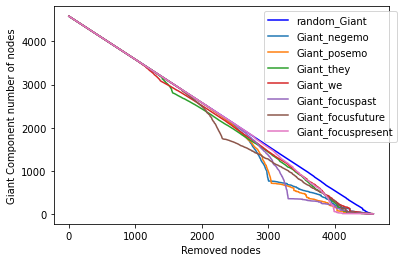

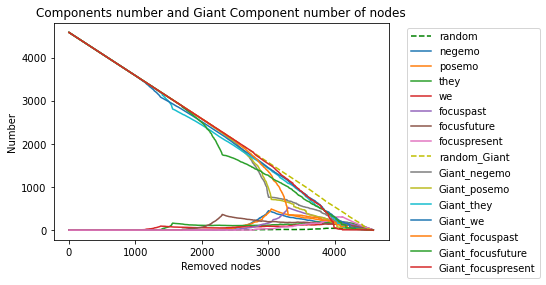

In [152]:
graph_robustness_random_emos(A2,emos)

::: Computing for random :::
::: Computing for negemo :::
::: Computing for posemo :::
::: Computing for they :::
::: Computing for we :::
::: Computing for focuspast :::
::: Computing for focusfuture :::
::: Computing for focuspresent :::
::: Plotting :::


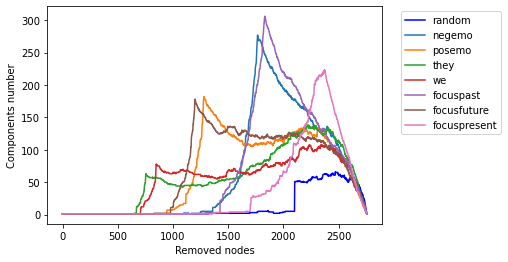

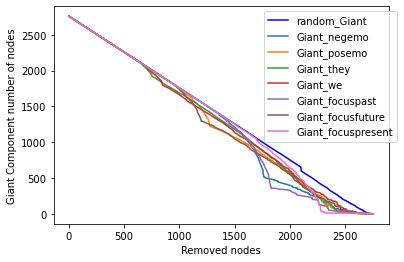

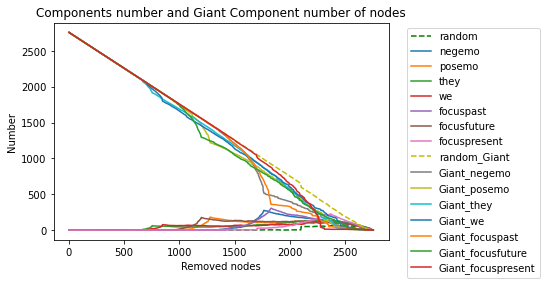

In [153]:
graph_robustness_random_emos(A1,emos)

::: Computing for random :::
::: Computing for negemo :::
::: Computing for posemo :::
::: Computing for they :::
::: Computing for we :::
::: Computing for focuspast :::
::: Computing for focusfuture :::
::: Computing for focuspresent :::
::: Plotting :::


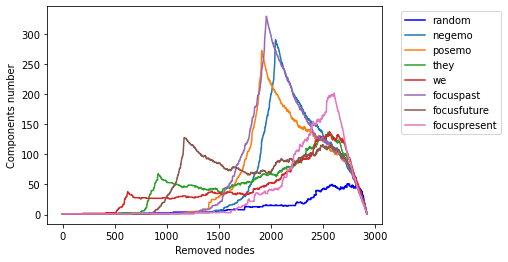

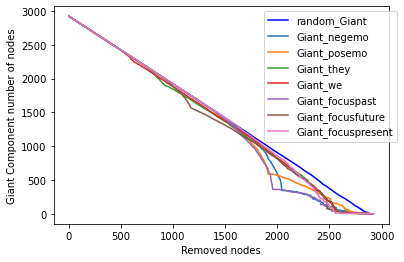

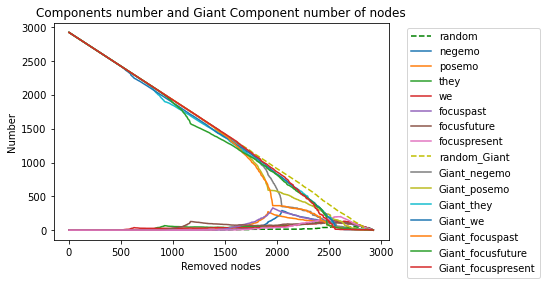

In [154]:
graph_robustness_random_emos(C1,emos)